In [2]:
import gc # memory management
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.feather as feather # load data
import re # rename columns 
import seaborn as sns
sns.set()

In [3]:
# Configuration
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# -----

# Fonctions

In [6]:
# Reduce Memory Usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        # type is int[8, 16, 32, 64] or float[16, 32, 64]
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [8]:
# Grab Column Names
def grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False):

    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "datetime64[ns]"]
    cat_cols = dataframe.select_dtypes(["object", "category"]).columns.tolist()
    
    num_but_cat = [col for col in dataframe.select_dtypes([
        "float", "integer"]).columns if dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.select_dtypes([
        "object", "category"]).columns if dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = dataframe.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'date_cols: {len(date_cols)}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = number of variables
    # num_but_cat already in cat_cols
    # all variables can be selected with all these 3 lists : cat_cols + num_cols + cat_but_car
    # num_but_cat is provided for reporting only

    if show_date == True:
        return date_cols, cat_cols, cat_but_car, num_cols, num_but_cat
    else:
        return cat_cols, cat_but_car, num_cols, num_but_cat

In [9]:
# Categorical Variables & Target
def cat_analyzer(dataframe, variable, target = None):
    print(variable)
    if target == None:
        print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe)}), end="\n\n\n")
    else:
        # selecting only rows w/ target
        temp = dataframe[dataframe[target].isnull() == False]
        print(pd.DataFrame({
            "COUNT":dataframe[variable].value_counts(),
            "RATIO":dataframe[variable].value_counts() / len(dataframe),
            "TARGET_COUNT":dataframe.groupby(variable)[target].count(),
            "TARGET_MEAN":temp.groupby(variable)[target].mean(),
            "TARGET_MEDIAN":temp.groupby(variable)[target].median(),
            "TARGET_STD":temp.groupby(variable)[target].std()}), end="\n\n\n")

In [10]:
# Numerical Variables
def corr_plot(data, remove=["Id"], corr_coef = "pearson", figsize=(20, 20)):
    
    # by default, remove at least Id column
    if len(remove) > 0:
        num_cols2 = [x for x in data.columns if (x not in remove)]

    sns.set(font_scale=1.1)
    c = data[num_cols2].corr(method = corr_coef)
    mask = np.triu(c.corr(method = corr_coef))
    plt.figure(figsize=figsize)
    sns.heatmap(c,
                annot=True,
                fmt='.1f',
                cmap='coolwarm',
                square=True,
                mask=mask,
                linewidths=1,
                cbar=False)
    plt.show()

In [11]:
# Plot numerical variables
def num_plot(data, num_cols, remove=["Id"], hist_bins=10, figsize=(20, 4)):

    if len(remove) > 0:
        num_cols2 = [x for x in num_cols if (x not in remove)]

    for i in num_cols2:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        data.hist(str(i), bins=hist_bins, ax=axes[0])
        data.boxplot(str(i), ax=axes[1], vert=False);
        try:
            sns.kdeplot(np.array(data[str(i)]))
        except:
            ValueError

        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(i + " | Histogram")
        axes[1].set_title(i + " | Boxplot")
        axes[2].set_title(i + " | Density")
        plt.show()

In [12]:
# Get high correlated variables
def high_correlation(data, remove=['SK_ID_CURR', 'SK_ID_BUREAU'], corr_coef="pearson", corr_value = 0.7):
    if len(remove) > 0:
        cols = [x for x in data.columns if (x not in remove)]
        c = data[cols].corr(method=corr_coef)
    else:
        c = data.corr(method=corr_coef)

    for i in c.columns:
        cr = c.loc[i].loc[(c.loc[i] >= corr_value) | (c.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")

In [13]:
# Missing Value
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")

In [14]:
# Quantile functions for aggregations
def quantile_funcs(percentiles = [0.75, 0.9, 0.99]):
    return [(p, lambda x: x.quantile(p)) for p in percentiles]

In [15]:
# Rare Encoder
def rare_encoder(data, col, rare_perc):
    temp = data[col].value_counts() / len(data) < rare_perc
    data[col] = np.where(~data[col].isin(temp[temp < rare_perc].index), "Rare", data[col])

# -----

# Chargement des données

In [16]:
# load all the files (except Description & Sample_Submission)
test = pd.read_csv("application_test.csv")
train = pd.read_csv("application_train.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
credit_card = pd.read_csv("credit_card_balance.csv")
installments = pd.read_csv("installments_payments.csv")
pos = pd.read_csv("POS_CASH_balance.csv")
previous = pd.read_csv("previous_application.csv")

In [26]:
print("DIMENSIONS:\n")

dict_df = {'application_test :' : test.shape,
           'application_train :': train.shape, 
           'bureau  :' : bureau.shape,
           'bureau_balance :' : bureau_balance.shape,
           'credit_card_balance :' : credit_card.shape,
           'installments_payments :' : installments.shape,
           'POS_CASH_balance :' : pos.shape, 
           'previous_application :' : previous.shape}

for key, value in dict_df.items():
    print(f'{key :-<30} {value}')

DIMENSIONS:

application_test :------------ (48744, 121)
application_train :----------- (307511, 122)
bureau  :--------------------- (1716428, 17)
bureau_balance :-------------- (27299925, 3)
credit_card_balance :--------- (3840312, 23)
installments_payments :------- (13605401, 8)
POS_CASH_balance :------------ (10001358, 8)
previous_application :-------- (1670214, 37)


### Balanced or Unbalanced?

In [21]:
cat_analyzer(train, "TARGET")

TARGET
    COUNT  RATIO
0  282686   0.92
1   24825   0.08




Il y a beaucoup plus de TARGET 0 que 1 : le jeu n'est pas du tout équilibré -> **Imbalanced**

### Intersections entre les df

In [23]:
#Train Test
print("Number of unique observations in the SK_ID_CURR \
variable: \n TRAIN: {} \n TEST : {}".format(
    train.SK_ID_CURR.nunique(), test.SK_ID_CURR.nunique()))


Number of unique observations in the SK_ID_CURR variable: 
 TRAIN: 307511 
 TEST : 48744


In [24]:
# Bureau & Bureau Balance
print("Number of unique observations in the SK_ID_BUREAU \
variable: \n BUREAU: {} \n BUREAU BALANCE: {} \n INTERSECTION: {}".format(
    bureau.SK_ID_BUREAU.nunique(),
    bureau_balance.SK_ID_BUREAU.nunique(),
    bureau[bureau.SK_ID_BUREAU.isin(
        bureau_balance.SK_ID_BUREAU.unique())].SK_ID_BUREAU.nunique()))


Number of unique observations in the SK_ID_BUREAU variable: 
 BUREAU: 1716428 
 BUREAU BALANCE: 817395 
 INTERSECTION: 774354


In [25]:
# Train-Test & Bureau
print("Number of unique observations in the SK_ID_CURR \
variable: \n TRAIN & BUREAU INTERSECTION: {} \n TEST \
& BUREAU INTERSECTION:  {} ".format(
    train[train.SK_ID_CURR.isin(bureau.SK_ID_CURR.unique())].SK_ID_CURR.nunique(),
    test[test.SK_ID_CURR.isin(bureau.SK_ID_CURR.unique())].SK_ID_CURR.nunique()))

Number of unique observations in the SK_ID_CURR variable: 
 TRAIN & BUREAU INTERSECTION: 263491 
 TEST & BUREAU INTERSECTION: 42320 


In [27]:
del train, test, bureau, bureau_balance, pos, credit_card, installments, previous

# Traitement de chaque df individuellement 

# 1) BUREAU BALANCE

### Description

This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [30]:
bureau_balance = pd.read_csv("bureau_balance.csv")
bureau_balance = reduce_mem_usage(bureau_balance)

print('shape :',bureau_balance.shape, "\n")

bureau_balance.head()

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
shape : (27299925, 3) 



,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


**STATUS** : 
    
C means closed,

X means status unknown,

0 means no DPD,

1 means maximal did during month between 1-30,

2 means DPD 31-60,

… 5 means DPD 120+ or sold or written off

### EDA for BUREAU BALANCE

In [31]:
# Are there any missing values in the data?
bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [32]:
# Descriptive Statistics
print(bureau_balance.MONTHS_BALANCE.agg({"min", "max", "mean", "median", "std"}))

print(96/12, " Max year")

median   -25.00
min      -96.00
max        0.00
std       23.86
mean     -30.74
Name: MONTHS_BALANCE, dtype: float64
8.0  Max year


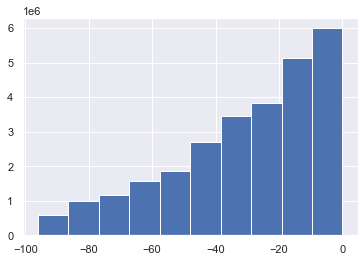

In [37]:
# Histogram
bureau_balance.MONTHS_BALANCE.hist()
plt.show()

In [38]:
bureau_balance.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

###  Data Manipulation & Feature Engineering for BUREAU BALANCE

In [40]:
# One-Hot Encoder : df & new_col
bb, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=False)

In [41]:
# Perform aggregations :

# min, max & size for MONTHS_BALANCE
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

# only mean for all the other cols (= cols from OH encoding)
for col in bb_cat:
    bb_aggregations[col] = ['mean']

bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
# after aggregation, columns w/ 2 levels > need to be renamed > and reindexed
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

In [42]:
# Status Sum
bb_agg["STATUS_C0_MEAN_SUM"] = bb_agg[["STATUS_C_MEAN", "STATUS_0_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN", "STATUS_2_MEAN"]].sum(axis = 1)
bb_agg["STATUS_345_MEAN_SUM"] = bb_agg[["STATUS_3_MEAN", "STATUS_4_MEAN",
                                        "STATUS_5_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12345_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN",
                                          "STATUS_2_MEAN",
                                          "STATUS_3_MEAN",
                                          "STATUS_4_MEAN",
                                          "STATUS_5_MEAN"]].sum(axis = 1)

In [43]:
# Find the first month when the credit is closed
closed = bureau_balance[bureau_balance.STATUS == "C"]
closed = closed.groupby("SK_ID_BUREAU").MONTHS_BALANCE.min().reset_index().rename(
    {"MONTHS_BALANCE":"MONTHS_BALANCE_FIRST_C"}, axis = 1)
closed["MONTHS_BALANCE_FIRST_C"] = np.abs(closed["MONTHS_BALANCE_FIRST_C"])

# calculate the difference 
bb_agg = pd.merge(bb_agg, closed, how = "left", on = "SK_ID_BUREAU")
bb_agg["MONTHS_BALANCE_CLOSED_DIF"] = np.abs(bb_agg.MONTHS_BALANCE_MIN) - bb_agg.MONTHS_BALANCE_FIRST_C

In [31]:
del closed, bb_aggregations, bureau_balance, bb_cat

In [44]:
print("BURAU BALANCE SHAPE:", bb_agg.shape, "\n")

bb_agg.head()

BURAU BALANCE SHAPE: (817395, 18) 



,SK_ID_BUREAU,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_C0_MEAN_SUM,STATUS_12_MEAN_SUM,STATUS_345_MEAN_SUM,STATUS_12345_MEAN_SUM,MONTHS_BALANCE_FIRST_C,MONTHS_BALANCE_CLOSED_DIF
0,5001709,-96,0,97,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.11,0.89,0.00,0.00,0.00,85.00,11.00
1,5001710,-82,0,83,0.06,0.00,0.00,0.00,0.00,0.00,0.58,0.36,0.64,0.00,0.00,0.00,47.00,35.00
2,5001711,-3,0,4,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.75,0.00,0.00,0.00,NaN,NaN
3,5001712,-18,0,19,0.53,0.00,0.00,0.00,0.00,0.00,0.47,0.00,1.00,0.00,0.00,0.00,8.00,10.00
4,5001713,-21,0,22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,NaN,NaN


# 2) BUREAU

### Description
1. All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
2. For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [45]:
bureau = pd.read_csv("bureau.csv")
bureau = reduce_mem_usage(bureau)

print('shape :',bureau.shape, "\n")

bureau.head()

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
shape : (1716428, 17) 



,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,"91,323.00",0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",NaN,NaN,0,"225,000.00","171,342.00",NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,"464,323.50",NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,"90,000.00",NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,"1,197.00",NaN,"77,674.50",0,"2,700,000.00",NaN,NaN,0.00,Consumer credit,-21,NaN


### Merge Bureau Balance and Bureau

In [46]:
# Left Join w/ BUREAU
bureau = pd.merge(bureau, bb_agg, how='left', on='SK_ID_BUREAU')
del bb_agg

print('shape :',bureau.shape, "\n")

bureau.head()

shape : (1716428, 34) 



,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_C0_MEAN_SUM,STATUS_12_MEAN_SUM,STATUS_345_MEAN_SUM,STATUS_12345_MEAN_SUM,MONTHS_BALANCE_FIRST_C,MONTHS_BALANCE_CLOSED_DIF
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,"91,323.00",0.00,NaN,0.00,Consumer credit,-131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",NaN,NaN,0,"225,000.00","171,342.00",NaN,0.00,Credit card,-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,"464,323.50",NaN,NaN,0.00,Consumer credit,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,"90,000.00",NaN,NaN,0.00,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,"1,197.00",NaN,"77,674.50",0,"2,700,000.00",NaN,NaN,0.00,Consumer credit,-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### EDA for BUREAU

In [47]:
# Are there any missing values in the data?
missing_values(bureau, plot = False)

Number of Variables include Missing Values: 24 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0   MONTHS_BALANCE_CLOSED_DIF      1299036           0.76   float64
1      MONTHS_BALANCE_FIRST_C      1299036           0.76   float64
2                 AMT_ANNUITY      1226791           0.71   float32
3      AMT_CREDIT_MAX_OVERDUE      1124488           0.66   float32
4               STATUS_5_MEAN       942074           0.55   float64
5               STATUS_0_MEAN       942074           0.55   float64
6               STATUS_1_MEAN       942074           0.55   float64
7               STATUS_2_MEAN       942074           0.55   float64
8               STATUS_3_MEAN       942074           0.55   float64
9               STATUS_4_MEAN       942074           0.55   float64
10              STATUS_C_MEAN       942074           0.55   float64
11         MONTHS_BALANCE_MAX       942074           0.55   float64
12              STATUS_X_MEAN       942074           0.55   float64

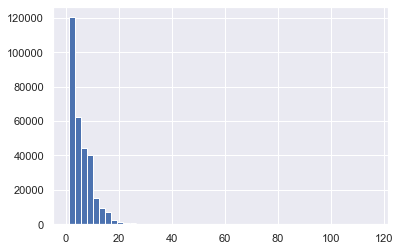

median     4.00
min        1.00
max      116.00
std        4.43
mean       5.61
Name: SK_ID_BUREAU, dtype: float64

In [48]:
# How many loans of each customer are there to from Credit Bureau?
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().hist(bins=50)
plt.show()

bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().agg({"min", "max", "mean", "median", "std"})

In [49]:
# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(bureau, car_th=10)

print("")

# Categorical Features
print('cat_cols :',cat_cols,'\ncat_but_car :', cat_but_car)

Observations: 1716428
Variables: 34
date_cols: 0
cat_cols: 2
num_cols: 23
cat_but_car: 1
num_but_cat: 0

cat_cols : ['CREDIT_ACTIVE', 'CREDIT_CURRENCY'] 
cat_but_car : ['CREDIT_TYPE']


In [50]:
# Cat Analyzer
for i in cat_cols + cat_but_car:
    cat_analyzer(bureau, i)

CREDIT_ACTIVE
            COUNT  RATIO
Closed    1079273   0.63
Active     630607   0.37
Sold         6527   0.00
Bad debt       21   0.00


CREDIT_CURRENCY
              COUNT  RATIO
currency 1  1715020   1.00
currency 2     1224   0.00
currency 3      174   0.00
currency 4       10   0.00


CREDIT_TYPE
                                                COUNT  RATIO
Consumer credit                               1251615   0.73
Credit card                                    402195   0.23
Car loan                                        27690   0.02
Mortgage                                        18391   0.01
Microloan                                       12413   0.01
Loan for business development                    1975   0.00
Another type of loan                             1017   0.00
Unknown type of loan                              555   0.00
Loan for working capital replenishment            469   0.00
Cash loan (non-earmarked)                          56   0.00
Real estate loan       

**CREDIT_CURRENCY** variable is useless for modelling. Almost all of rows are currency 1 category.

**CREDIT_ACTIVE** variable might be useful. There are two rare categories in this column. We can combine these two categories so we assign a new category as Sold_BadDebt. Briefly, CREDIT_ACTIVE variable includes 3 categories as Active, Closed and Sold_BadDebt.

**CREDIT_TYPE** might be useful but there are some rare categories too. We should reduce number of category.

In [51]:
# Numeric Features
bureau.drop(["SK_ID_CURR" ,"SK_ID_BUREAU"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_C0_MEAN_SUM,STATUS_12_MEAN_SUM,STATUS_345_MEAN_SUM,STATUS_12345_MEAN_SUM,MONTHS_BALANCE_FIRST_C,MONTHS_BALANCE_CLOSED_DIF
mean,"-1,142.11",0.82,NaN,NaN,"3,825.36",0.01,"354,577.31","137,081.83","6,229.78",37.91,-593.75,"15,713.27",-36.29,-6.06,31.23,0.41,0.01,0.00,0.00,0.00,0.00,0.36,0.22,0.77,0.01,0.00,0.01,31.74,11.76
std,795.16,36.54,NaN,NaN,"205,987.31",0.10,"1,150,276.62","679,074.88","44,896.66","5,937.52",720.75,"325,655.59",25.45,15.06,23.48,0.35,0.05,0.01,0.00,0.00,0.03,0.37,0.34,0.34,0.05,0.03,0.06,22.91,10.78
min,"-2,922.00",0.00,"-42,048.00","-42,016.00",0.00,0.00,0.00,"-4,705,600.50","-586,406.12",0.00,"-41,947.00",0.00,-96.00,-95.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,"-2,867.00",0.00,"-2,572.00","-2,640.00",0.00,0.00,0.00,0.00,0.00,0.00,"-2,531.00",0.00,-93.00,-72.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,"-2,443.00",0.00,"-1,922.00","-2,160.00",0.00,0.00,"22,500.00",0.00,0.00,0.00,"-1,561.00",0.00,-78.00,-25.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,3.00
25%,"-1,666.00",0.00,"-1,138.00","-1,489.00",0.00,0.00,"51,300.00",0.00,0.00,0.00,-908.00,0.00,-53.00,0.00,12.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,0.00,0.00,0.00,13.00,5.00
50%,-987.00,0.00,-330.00,-897.00,0.00,0.00,"125,518.50",0.00,0.00,0.00,-395.00,0.00,-31.00,0.00,25.00,0.33,0.00,0.00,0.00,0.00,0.00,0.24,0.03,0.95,0.00,0.00,0.00,28.00,9.00
75%,-474.00,0.00,474.00,-425.00,0.00,0.00,"315,000.00","40,153.50",0.00,0.00,-33.00,"13,500.00",-15.00,0.00,45.00,0.73,0.00,0.00,0.00,0.00,0.00,0.74,0.31,1.00,0.00,0.00,0.00,46.00,13.00
80%,-385.00,0.00,725.00,-340.00,45.00,0.00,"423,000.00","90,009.00",0.00,0.00,-25.00,"17,660.21",-12.00,0.00,50.00,0.83,0.00,0.00,0.00,0.00,0.00,0.80,0.44,1.00,0.00,0.00,0.00,52.00,17.00
90%,-215.00,0.00,"1,334.00",-178.00,"7,594.88",0.00,"778,754.75","295,456.50",0.00,0.00,-13.00,"31,432.50",-7.00,0.00,67.00,0.97,0.02,0.00,0.00,0.00,0.00,0.88,1.00,1.00,0.03,0.00,0.03,68.00,24.00


**Rq :** AMT_CREDIT_MAX_OVERDUE variable maximum value is 115,987,184.00 but 99 percentile is 41,988.75. This difference is too much between max and 99% values >> Outliers to be removed.

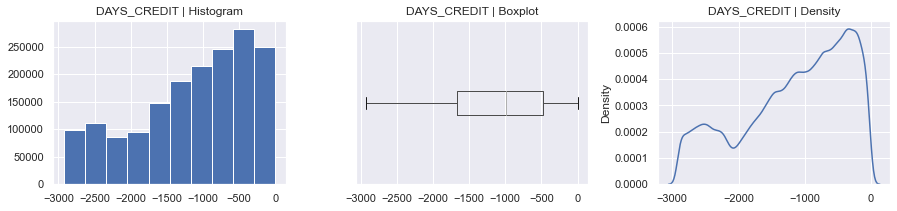

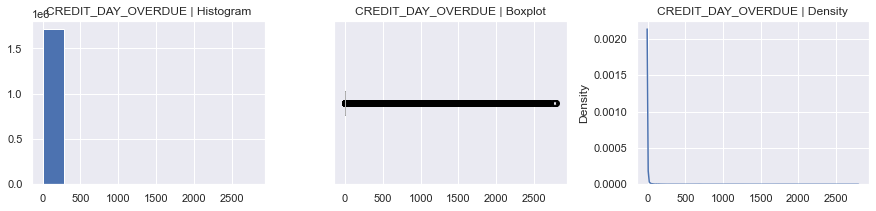

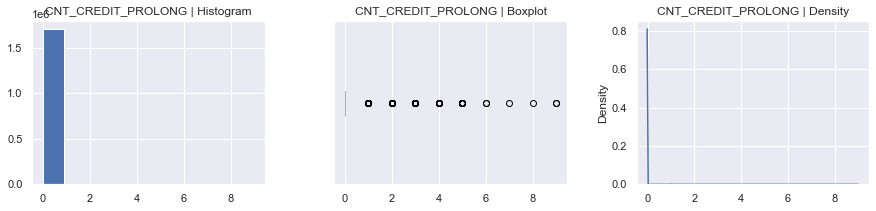

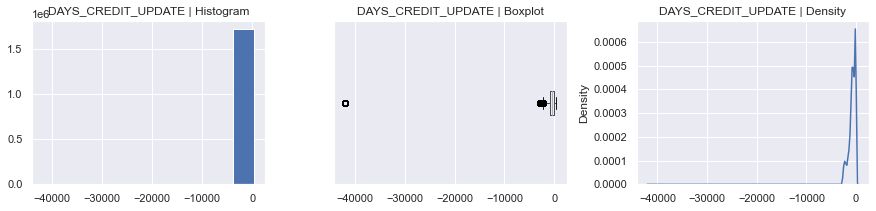

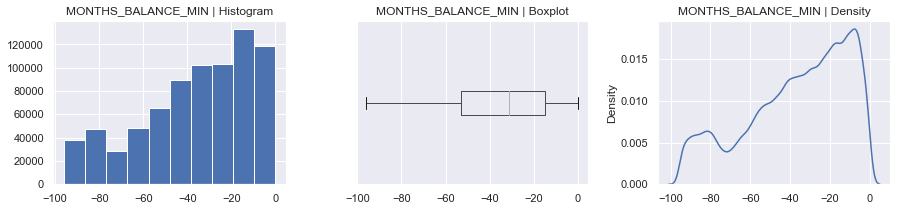

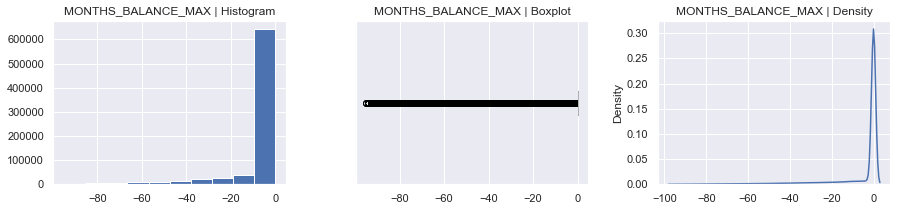

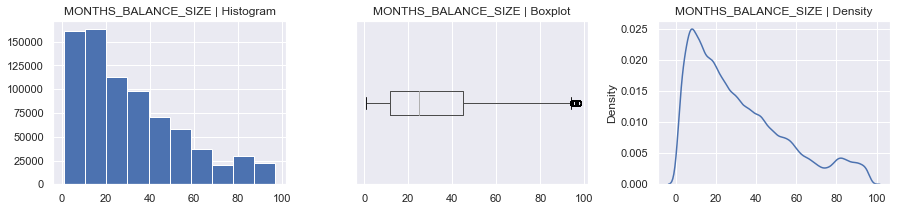

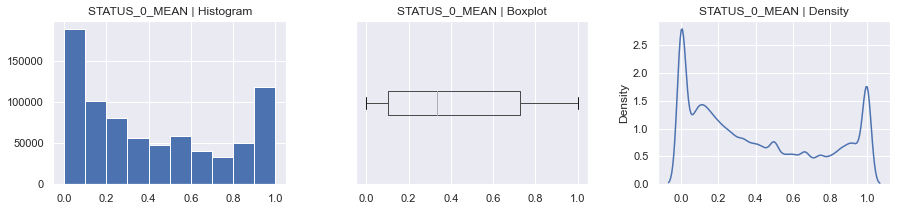

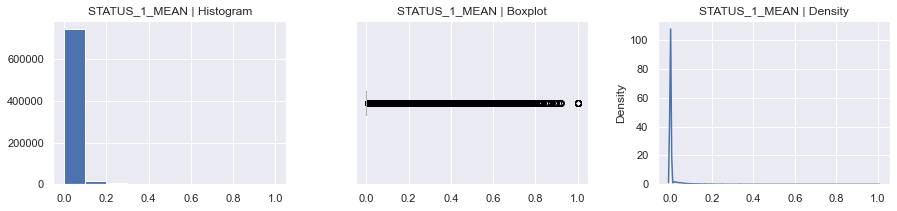

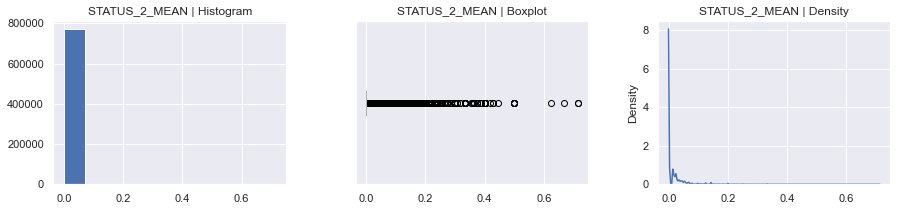

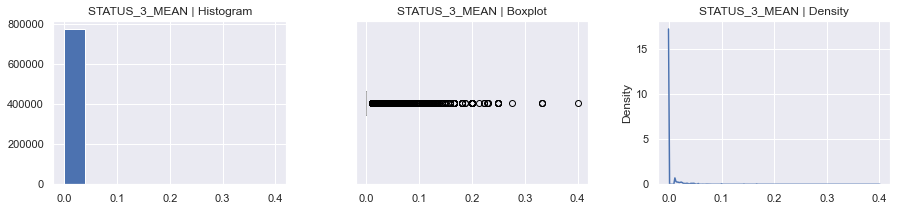

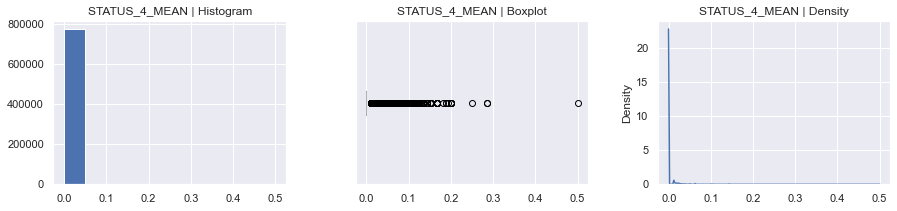

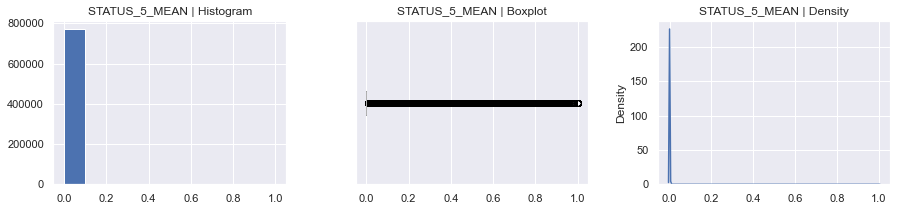

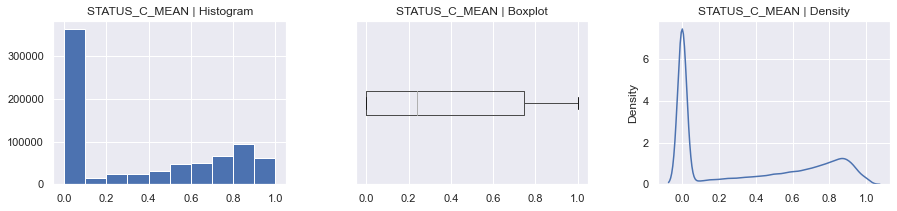

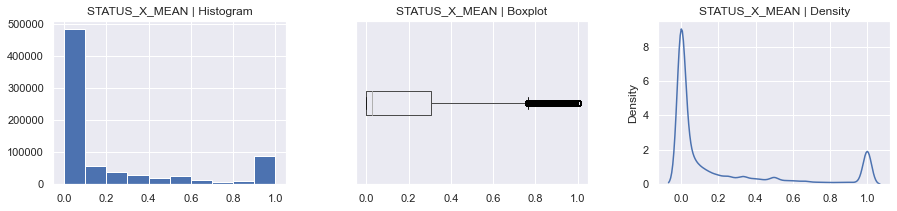

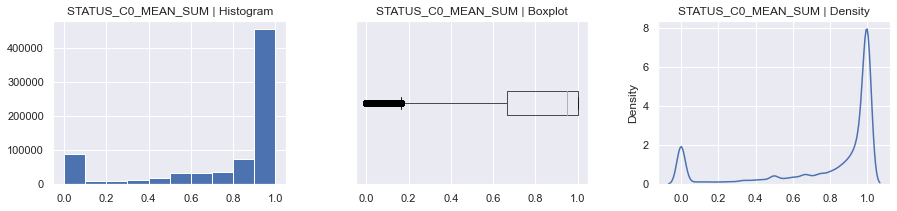

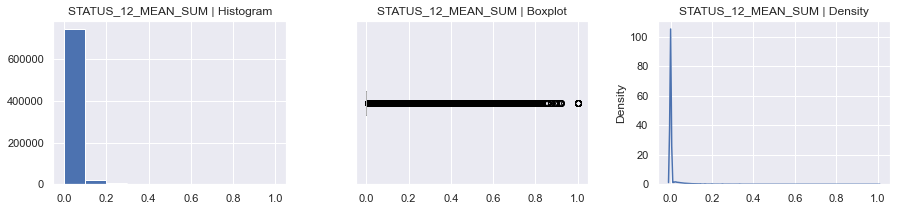

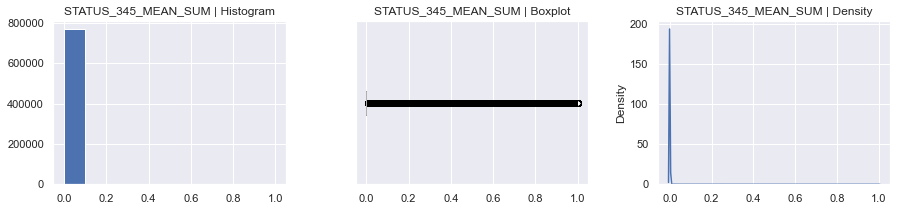

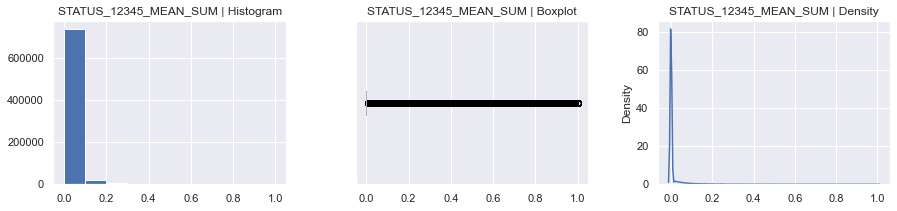

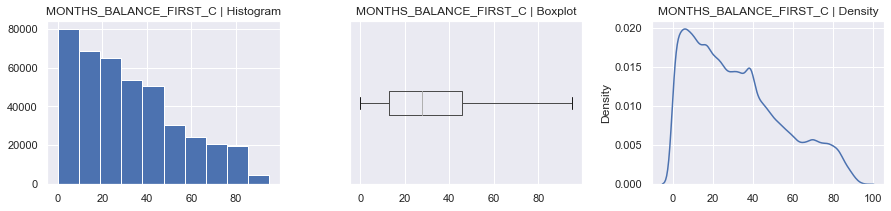

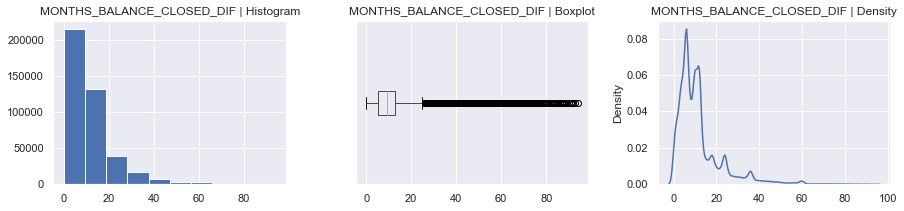

In [52]:
# Quick Visualization for numerical variables
num_plot(bureau, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_BUREAU'], figsize = (15,3))

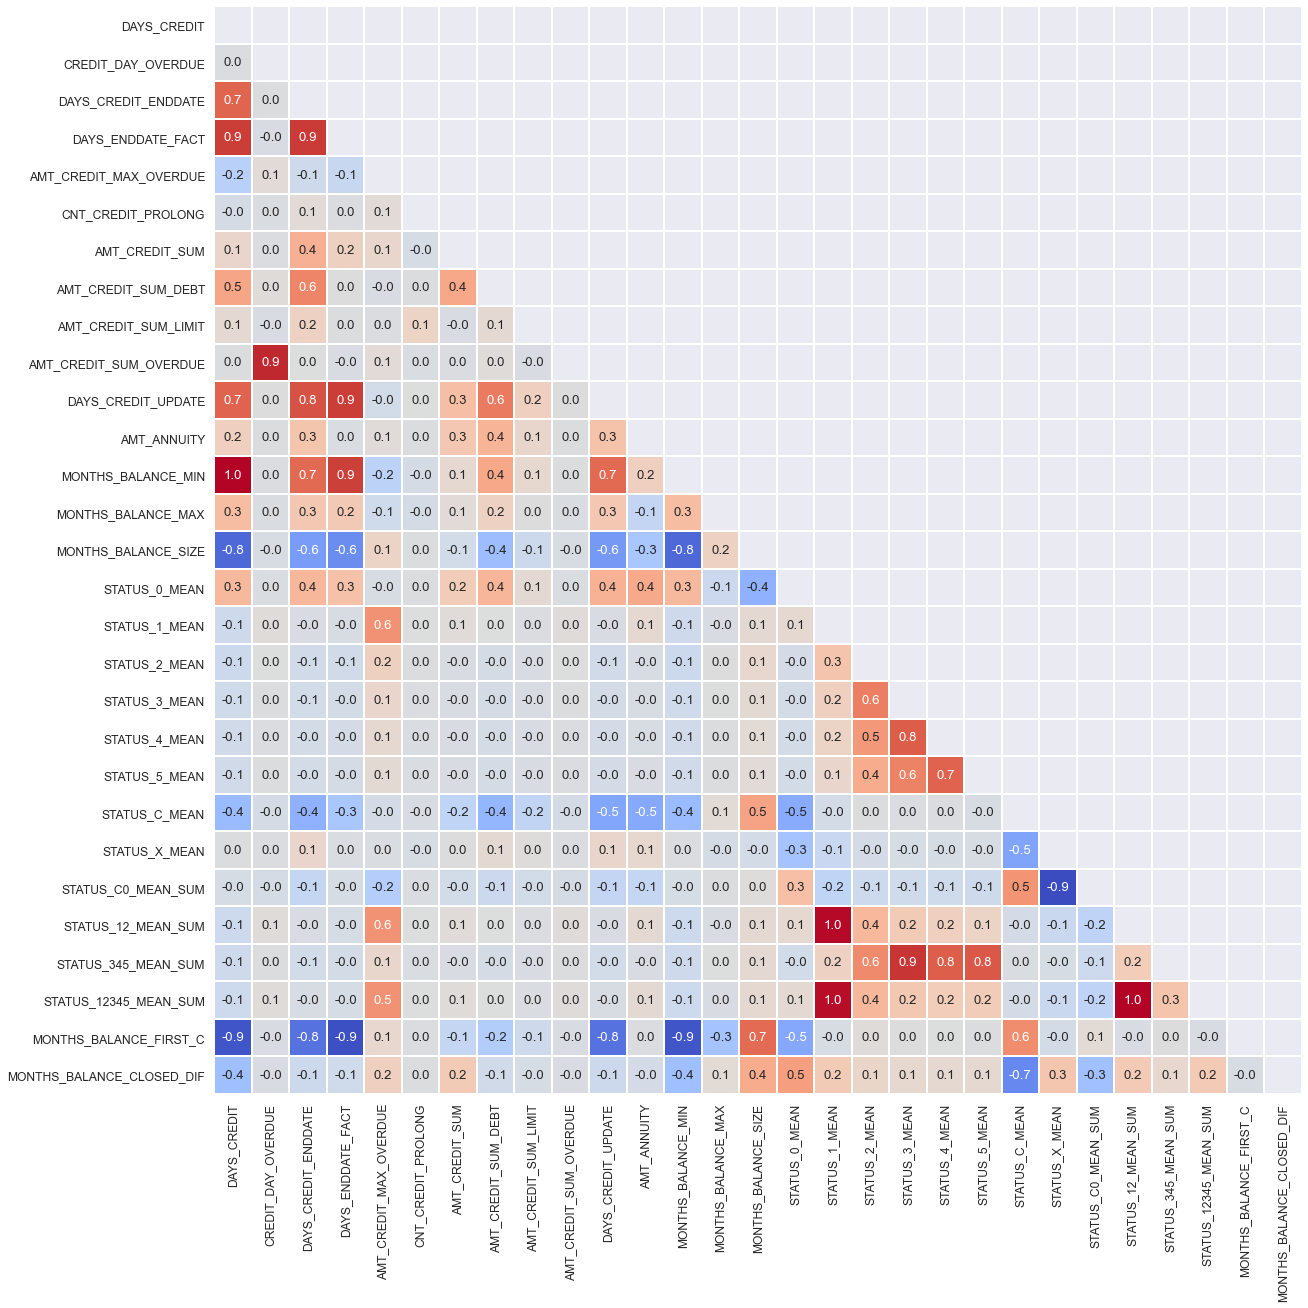

In [53]:
# Correlation
corr_plot(bureau, remove=['SK_ID_CURR','SK_ID_BUREAU'], corr_coef = "spearman")

In [54]:
high_correlation(bureau, remove=['SK_ID_CURR','SK_ID_BUREAU'], corr_coef = "spearman", corr_value = 0.7)

DAYS_CREDIT
-------------------------------
MONTHS_BALANCE_MIN        1.00
DAYS_ENDDATE_FACT         0.87
DAYS_CREDIT_UPDATE        0.74
DAYS_CREDIT_ENDDATE       0.74
MONTHS_BALANCE_SIZE      -0.82
MONTHS_BALANCE_FIRST_C   -0.90
Name: DAYS_CREDIT, dtype: float64


CREDIT_DAY_OVERDUE
-------------------------------
AMT_CREDIT_SUM_OVERDUE   0.93
Name: CREDIT_DAY_OVERDUE, dtype: float64


DAYS_CREDIT_ENDDATE
-------------------------------
DAYS_ENDDATE_FACT         0.88
DAYS_CREDIT_UPDATE        0.81
DAYS_CREDIT               0.74
MONTHS_BALANCE_MIN        0.72
MONTHS_BALANCE_FIRST_C   -0.77
Name: DAYS_CREDIT_ENDDATE, dtype: float64


DAYS_ENDDATE_FACT
-------------------------------
DAYS_CREDIT_ENDDATE       0.88
DAYS_CREDIT               0.87
DAYS_CREDIT_UPDATE        0.87
MONTHS_BALANCE_MIN        0.87
MONTHS_BALANCE_FIRST_C   -0.92
Name: DAYS_ENDDATE_FACT, dtype: float64


AMT_CREDIT_SUM_OVERDUE
-------------------------------
CREDIT_DAY_OVERDUE   0.93
Name: AMT_CREDIT_SUM_OVERDUE, d

### Data Manipulation & Feature Engineering for BUREAU

##### Feature engineering for BUREAU ... 

##### ... Numerical Variables

In [58]:
# Bureau and bureau_balance numeric features
cal = ['min', 'max', 'mean', 'sum', 'median','std']
cols1 = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_CREDIT_UPDATE',
         'CREDIT_DAY_OVERDUE','AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM',
         'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE','AMT_CREDIT_SUM_LIMIT',
         'AMT_ANNUITY', 'CNT_CREDIT_PROLONG', 'MONTHS_BALANCE_MIN','MONTHS_BALANCE_MAX',
         'MONTHS_BALANCE_SIZE', 'MONTHS_BALANCE_FIRST_C', 'MONTHS_BALANCE_CLOSED_DIF']

num_aggregations = {}

for i in cols1:
    num_aggregations[i] = cal

##### ... Categorical Variables

In [55]:
# Useless
bureau.drop("CREDIT_CURRENCY", axis = 1, inplace = True)

In [56]:
# Rare Categories
bureau["CREDIT_ACTIVE"] = np.where(
    bureau.CREDIT_ACTIVE.isin(["Sold", "Bad debt"]),
    "Sold_BadDebt",
    bureau.CREDIT_ACTIVE)

bureau["CREDIT_TYPE"] = np.where(
    ~bureau.CREDIT_TYPE.isin(
        ["Consumer credit", "Credit card", "Car loan", "Mortgage", "Microloan"]),
    "Other",
    bureau["CREDIT_TYPE"])

In [57]:
# One-Hot Encoder
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=False)

In [63]:
# Bureau and bureau_balance categorical features
cat_aggregations = {}

for i in bureau_cat:
    cat_aggregations[i] = ['mean']

cols2 = ['STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN', 'STATUS_4_MEAN',
        'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN', 'STATUS_C0_MEAN_SUM',
        'STATUS_12_MEAN_SUM', 'STATUS_345_MEAN_SUM', 'STATUS_12345_MEAN_SUM']

for i in cols2:
    cat_aggregations[i] = ['mean', 'median', 'sum', 'max', 'std']

In [48]:
del  cal, cols1, cols2, i, bureau_cat

In [65]:
# Create aggregated data
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [66]:
# New features
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().value_counts()

bcount = bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().reset_index().rename(
    {"SK_ID_BUREAU":"BUREAU_COUNT"}, axis = 1)
# categ_1 : categ qui ont moins de 4 individus (I think)
bcount["BUREAU_COUNT_CAT"] = np.where(bcount.BUREAU_COUNT < 4, 0, 1)
# 8 < categ_2 < 13
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 8) & (bcount.BUREAU_COUNT < 13),
                                      2, bcount["BUREAU_COUNT_CAT"])
# 13 < categ_3 < 20
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 13) & (bcount.BUREAU_COUNT < 20),
                                      3, bcount["BUREAU_COUNT_CAT"])
# 20 < categ_4
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 20),
                                      4, bcount["BUREAU_COUNT_CAT"])

bureau_agg = pd.merge(bureau_agg, bcount, how = "left", on = "SK_ID_CURR")

In [67]:
del bcount

In [68]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])

bureau_agg = pd.merge(bureau_agg, active_agg, how='left', on='SK_ID_CURR')

In [69]:
del active, active_agg

In [70]:
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])

bureau_agg = pd.merge(bureau_agg, closed_agg, how='left', on='SK_ID_CURR')

In [71]:
del closed, closed_agg

In [72]:
# Bureau: Sold and Bad Debt credits - using only numerical aggregations
sold_baddebt = bureau[bureau['CREDIT_ACTIVE_Sold_BadDebt'] == 1]
sold_baddebt_agg = sold_baddebt.groupby('SK_ID_CURR').agg(num_aggregations)
sold_baddebt_agg.columns = pd.Index(['SOLD_BADDEBT' + e[0] + "_" + e[1].upper()
                                     for e in sold_baddebt_agg.columns.tolist()])

bureau_agg = pd.merge(bureau_agg, sold_baddebt_agg, how='left', on='SK_ID_CURR')

In [73]:
del sold_baddebt, sold_baddebt_agg, bureau

In [74]:
del num_aggregations, cat_aggregations

In [75]:
# WRITE FEATHER
bureau_agg.to_feather("bureau_bureaubalance_agg_feather")
#pd.read_feather("./bureau_bureaubalance_agg_feather")

print("BUREAU & BURAU BALANCE SHAPE:", bureau_agg.shape, "\n")

bureau_agg.head()

BUREAU & BURAU BALANCE SHAPE: (305811, 456) 



,SK_ID_CURR,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_SUM,BUREAU_CREDIT_DAY_OVERDUE_MEDIAN,BUREAU_CREDIT_DAY_OVERDUE_STD,BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_MIN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MEDIAN,BUREAU_AMT_CREDIT_SUM_STD,BUREAU_AMT_CREDIT_SUM_DEBT_MIN,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MEDIAN,BUREAU_AMT_CREDIT_SUM_DEBT_STD,BUREAU_AMT_CREDIT_SUM_OVERDUE_MIN,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_LIMIT_MIN,BUREAU_AMT_CREDIT_SUM_LIMIT_MAX,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEDIAN,BUREAU_AMT_CREDIT_SUM_LIMIT_STD,BUREAU_AMT_ANNUITY_MIN,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_ANNUITY_MEDIAN,BUREAU_AMT_ANNUITY_STD,BUREAU_CNT_CREDIT_PROLONG_MIN,BUREAU_CNT_CREDIT_PROLONG_MAX,BUREAU_CNT_CREDIT_PROLONG_MEAN,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_CNT_CREDIT_PROLONG_MEDIAN,BUREAU_CNT_CREDIT_PROLONG_STD,BUREAU_MONTHS_BALANCE_MIN_MIN,BUREAU_MONTHS_BALANCE_MIN_MAX,BUREAU_MONTHS_BALANCE_MIN_MEAN,BUREAU_MONTHS_BALANCE_MIN_SUM,BUREAU_MONTHS_BALANCE_MIN_MEDIAN,BUREAU_MONTHS_BALANCE_MIN_STD,BUREAU_MONTHS_BALANCE_MAX_MIN,BUREAU_MONTHS_BALANCE_MAX_MAX,BUREAU_MONTHS_BALANCE_MAX_MEAN,BUREAU_MONTHS_BALANCE_MAX_SUM,BUREAU_MONTHS_BALANCE_MAX_MEDIAN,BUREAU_MONTHS_BALANCE_MAX_STD,BUREAU_MONTHS_BALANCE_SIZE_MIN,BUREAU_MONTHS_BALANCE_SIZE_MAX,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_MONTHS_BALANCE_SIZE_MEDIAN,BUREAU_MONTHS_BALANCE_SIZE_STD,BUREAU_MONTHS_BALANCE_FIRST_C_MIN,BUREAU_MONTHS_BALANCE_FIRST_C_MAX,BUREAU_MONTHS_BALANCE_FIRST_C_MEAN,BUREAU_MONTHS_BALANCE_FIRST_C_SUM,BUREAU_MONTHS_BALANCE_FIRST_C_MEDIAN,BUREAU_MONTHS_BALANCE_FIRST_C_STD,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MIN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MAX,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_SUM,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEDIAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_STD,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_BadDebt_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Other_MEAN,BUREAU_STATUS_0_MEAN_MEAN,BUREAU_STATUS_0_MEAN_MEDIAN,BUREAU_STATUS_0_MEAN_SUM,BUREAU_STATUS_0_MEAN_MAX,BUREAU_STATUS_0_MEAN_STD,BUREAU_STATUS_1_MEAN_MEAN,BUREAU_STATUS_1_MEAN_MEDIAN,BUREAU_STATUS_1_MEAN_SUM,BUREAU_STATUS_1_MEAN_MAX,BUREAU_STATUS_1_MEAN_STD,BUREAU_STATUS_2_MEAN_MEAN,BUREAU_STATUS_2_MEAN_MEDIAN,BUREAU_STATUS_2_MEAN_SUM,BUREAU_STATUS_2_MEAN_MAX,BUREAU_STATUS_2_MEAN_STD,BUREAU_STATUS_3_MEAN_MEAN,BUREAU_STATUS_3_MEAN_MEDIAN,BUREAU_STATUS_3_MEAN_SUM,BUREAU_STATUS_3_MEAN_MAX,BUREAU_STATUS_3_MEAN_STD,BUREAU_STATUS_4_MEAN_MEAN,BUREAU_STATUS_4_MEAN_MEDIAN,BUREAU_STATUS_4_MEAN_SUM,BUREAU_STATUS_4_MEAN_MAX,BUREAU_STATUS_4_MEAN_STD,BUREAU_STATUS_5_MEAN_MEAN,BUREAU_STATUS_5_MEAN_MEDIA

In [60]:
# del bureau, bureau_agg

# 3) POS CASH BALANCE

### Description
1. Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
2. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [76]:
pos = pd.read_csv('POS_CASH_balance.csv')
pos = reduce_mem_usage(pos)

print('shape :',pos.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(pos, car_th=10)

print("")

pos.head()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%
shape : (10001358, 8) 

Observations: 10001358
Variables: 8
date_cols: 0
cat_cols: 1
num_cols: 5
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0
2,1784872,397406,-32,12.00,9.00,Active,0,0
3,1903291,269225,-35,48.00,42.00,Active,0,0
4,2341044,334279,-35,36.00,35.00,Active,0,0


### EDA for Pos Cash Balance

In [77]:
# Are there any missing values in the data?
missing_values(pos, plot = False)

Number of Variables include Missing Values: 2 

                 Feature  Num_Missing  Missing_Ratio DataTypes
0  CNT_INSTALMENT_FUTURE        26087           0.00   float16
1         CNT_INSTALMENT        26071           0.00   float16 



In [78]:
# Cat Analyzer
cat_analyzer(pos, "NAME_CONTRACT_STATUS")

NAME_CONTRACT_STATUS
                         COUNT  RATIO
Active                 9151119   0.91
Completed               744883   0.07
Signed                   87260   0.01
Demand                    7065   0.00
Returned to the store     5461   0.00
Approved                  4917   0.00
Amortized debt             636   0.00
Canceled                    15   0.00
XNA                          2   0.00




In [79]:
# Numeric Features
pos.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
mean,-35.01,NaN,NaN,11.61,0.65
std,26.07,0.00,0.00,132.71,32.76
min,-96.00,1.00,0.00,0.00,0.00
1%,-94.00,4.00,0.00,0.00,0.00
10%,-77.00,6.00,0.00,0.00,0.00
25%,-54.00,10.00,3.00,0.00,0.00
50%,-28.00,12.00,7.00,0.00,0.00
75%,-13.00,24.00,14.00,0.00,0.00
80%,-11.00,24.00,17.00,0.00,0.00
90%,-6.00,36.00,24.00,0.00,0.00


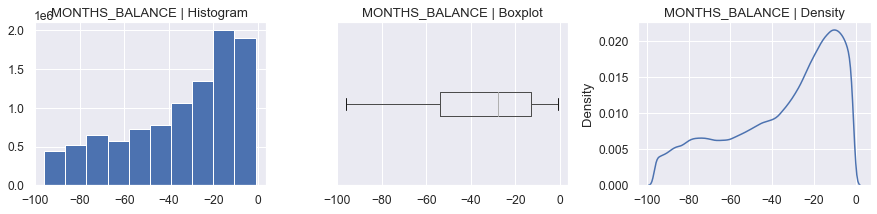

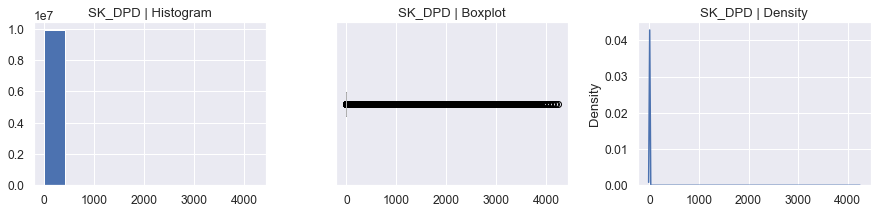

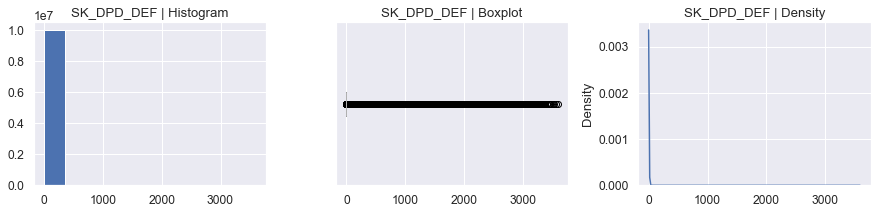

In [80]:
# Quick Visualization for numerical variables
num_plot(pos, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

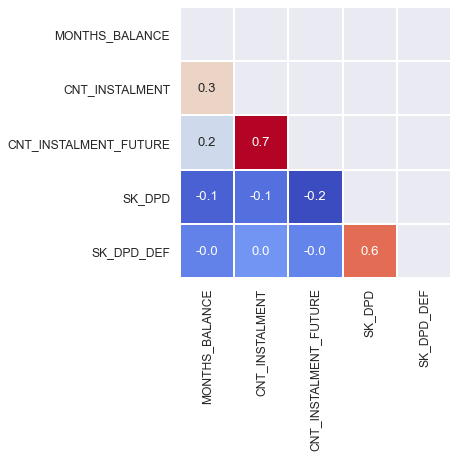

In [81]:
# Correlation
corr_plot(pos, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (5,5))

### Data Manipulation & Feature Engineering for Pos Cash Balance

In [82]:
# Rare
pos["NAME_CONTRACT_STATUS"] = np.where(~(pos["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", pos["NAME_CONTRACT_STATUS"])

In [83]:
# One-Hot Encoder
pos, cat_cols = one_hot_encoder(pos, nan_as_category=False)

In [84]:
# Numerical aggregations

aggregations = {'MONTHS_BALANCE': ['max', 'mean', 'size'],
                'CNT_INSTALMENT': ['max', 'mean', 'std', 'min', 'median'],
                'CNT_INSTALMENT_FUTURE':
                ['max', 'mean', 'sum', 'min', 'median', 'std'],
                'SK_DPD': ['max', 'mean'],
                'SK_DPD_DEF': ['max', 'mean']}
# Categorical aggregations
for cat in cat_cols:
    aggregations[cat] = ['mean']

In [85]:
# Aggregation
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
pos_agg.reset_index(inplace = True)

In [86]:
del pos, cat_cols, aggregations

In [87]:
print("POS CASH BALANCE SHAPE:", pos_agg.shape, "\n")
pos_agg.head()

POS CASH BALANCE SHAPE: (337252, 23) 



,SK_ID_CURR,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Rare_MEAN,POS_COUNT
0,100001,-53,-72.56,9,4.00,4.00,0.00,4.00,4.00,4.00,1.44,13.00,0.00,1.00,1.42,7,0.78,7,0.78,0.78,0.22,0.00,9
1,100002,-1,-10.00,19,24.00,24.00,0.00,24.00,24.00,24.00,15.00,285.00,6.00,15.00,5.63,0,0.00,0,0.00,1.00,0.00,0.00,19
2,100003,-18,-43.79,28,12.00,10.11,2.81,6.00,12.00,12.00,5.79,162.00,0.00,6.00,3.84,0,0.00,0,0.00,0.93,0.07,0.00,28
3,100004,-24,-25.50,4,4.00,3.75,0.50,3.00,4.00,4.00,2.25,9.00,0.00,2.50,1.71,0,0.00,0,0.00,0.75,0.25,0.00,4
4,100005,-15,-20.00,11,12.00,11.70,0.95,9.00,12.00,12.00,7.20,72.00,0.00,7.50,3.61,0,0.00,0,0.00,0.82,0.09,0.09,11


In [88]:
# WRITE FEATHER
pos_agg.to_feather("poscashbalance_agg_feather")

In [89]:
del pos_agg

# 4) CREDIT CARD BALANCE

### Description 
1. Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
2. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [90]:
cc = pd.read_csv('credit_card_balance.csv')
cc = reduce_mem_usage(cc)

print('shape :', cc.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(cc, car_th=10)

print("")

cc.head()

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
shape : (3840312, 23) 

Observations: 3840312
Variables: 23
date_cols: 0
cat_cols: 1
num_cols: 7
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,"1,700.32","1,800.00","1,800.00",0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,"63,975.55",45000,"2,250.00","2,250.00",0.00,0.00,"2,250.00","2,250.00","2,250.00","60,175.08","64,875.55","64,875.55",1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,"31,815.22",450000,0.00,0.00,0.00,0.00,"2,250.00","2,250.00","2,250.00","26,926.43","31,460.09","31,460.09",0.00,0,0.00,0.00,30.00,Active,0,0
3,1389973,337855,-4,"236,572.11",225000,"2,250.00","2,250.00",0.00,0.00,"11,795.76","11,925.00","11,925.00","224,949.28","233,048.97","233,048.97",1.00,1,0.00,0.00,10.00,Active,0,0
4,1891521,126868,-1,"453,919.47",450000,0.00,"11,547.00",0.00,"11,547.00","22,924.89","27,000.00","27,000.00","443,044.41","453,919.47","453,919.47",0.00,1,0.00,1.00,101.00,Active,0,0


### EDA for Credit Card Balance

In [91]:
# Are there any missing values in the data?
missing_values(cc, plot = False)

Number of Variables include Missing Values: 9 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0         AMT_PAYMENT_CURRENT       767988           0.20   float32
1    AMT_DRAWINGS_ATM_CURRENT       749816           0.20   float32
2    CNT_DRAWINGS_POS_CURRENT       749816           0.20   float16
3  AMT_DRAWINGS_OTHER_CURRENT       749816           0.20   float32
4    AMT_DRAWINGS_POS_CURRENT       749816           0.20   float32
5  CNT_DRAWINGS_OTHER_CURRENT       749816           0.20   float16
6    CNT_DRAWINGS_ATM_CURRENT       749816           0.20   float16
7   CNT_INSTALMENT_MATURE_CUM       305236           0.08   float16
8     AMT_INST_MIN_REGULARITY       305236           0.08   float32 



In [92]:
# Cat Analyzer
cat_analyzer(cc, "NAME_CONTRACT_STATUS")

NAME_CONTRACT_STATUS
                 COUNT  RATIO
Active         3698436   0.96
Completed       128918   0.03
Signed           11058   0.00
Demand            1365   0.00
Sent proposal      513   0.00
Refused             17   0.00
Approved             5   0.00




In [93]:
# Numeric Features
cc.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
mean,-34.52,"58,276.86","153,807.96","5,962.30","7,432.26",288.16,"2,968.84","3,541.78","10,211.03","7,564.77","55,950.36","58,085.02","58,094.59",NaN,0.70,0.00,NaN,NaN,9.28,0.33
std,26.67,"107,464.14","165,145.70","28,033.97","33,366.82","8,197.02","20,663.21","5,525.35","35,791.42","31,594.29","101,517.74","107,176.88","107,180.20",0.00,3.19,0.08,0.00,0.00,97.52,21.48
min,-96.00,"-420,250.19",0.00,"-6,827.31","-6,211.62",0.00,0.00,0.00,0.00,0.00,"-423,305.81","-420,250.19","-420,250.19",0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,-93.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-487.26,-486.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,-76.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-55.00,0.00,"45,000.00",0.00,0.00,0.00,0.00,0.00,152.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00
50%,-28.00,0.00,"112,500.00",0.00,0.00,0.00,0.00,0.00,"2,702.70",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,0.00,0.00
75%,-11.00,"89,046.69","180,000.00",0.00,0.00,0.00,0.00,"6,633.91","9,000.00","6,750.00","85,359.24","88,899.49","88,914.51",0.00,0.00,0.00,0.00,32.00,0.00,0.00
80%,-9.00,"116,880.70","225,000.00",0.00,0.00,0.00,0.00,"7,283.97","10,800.00","9,000.00","111,982.27","116,663.39","116,690.04",0.00,0.00,0.00,0.00,37.00,0.00,0.00
90%,-5.00,"180,016.20","427,500.00","6,750.00","11,250.00",0.00,0.00,"9,000.00","18,900.00","13,500.00","173,228.92","179,815.77","179,830.17",1.00,1.00,0.00,0.00,51.00,0.00,0.00


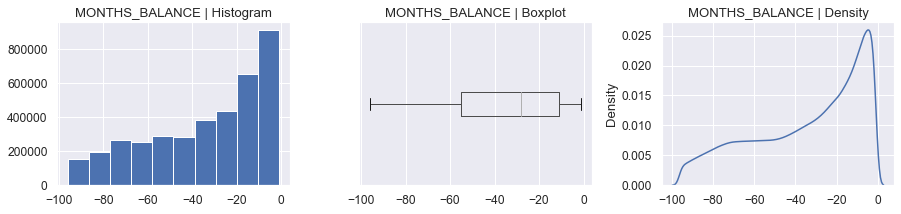

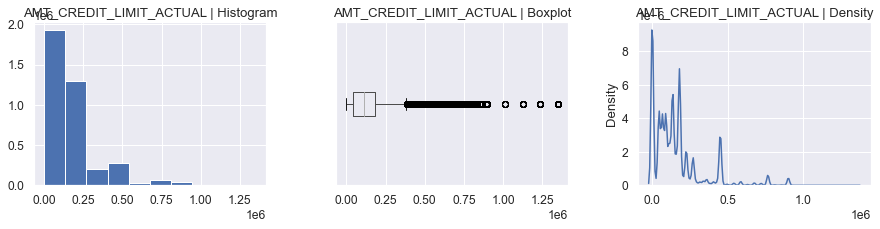

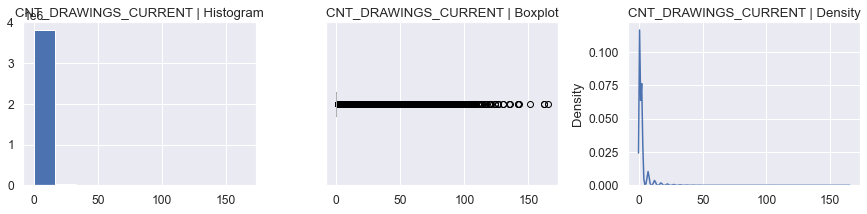

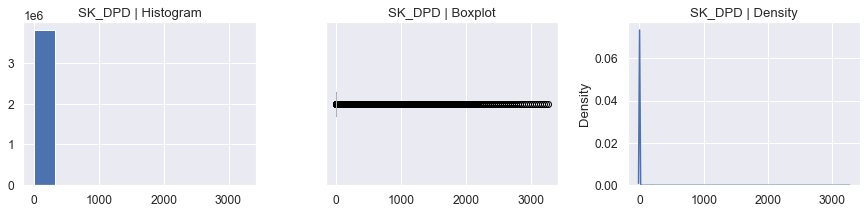

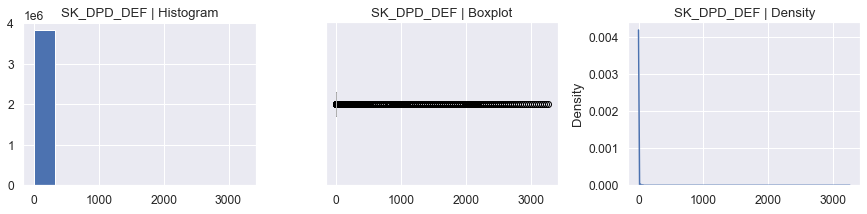

In [94]:
# Quick Visualization for numerical variables
num_plot(cc, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

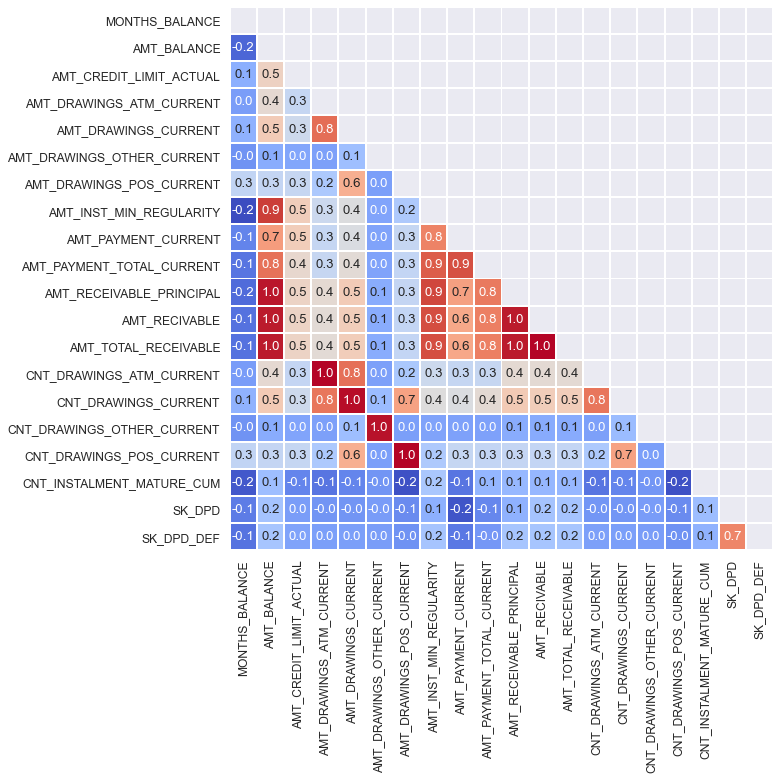

In [95]:
# Correlation
corr_plot(cc, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (10,10))

### Data Manipulation & Feature Engineering for Credit Card Balance

In [96]:
# Rare
cc["NAME_CONTRACT_STATUS"] = np.where(~(cc["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", cc["NAME_CONTRACT_STATUS"])

In [97]:
# One Hot Encoder
cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)

In [98]:
# General aggregations
cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'std'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
cc_agg.reset_index(inplace = True)

In [99]:
del cc

In [100]:
print("CREDIT CARD BALANCE SHAPE:", cc_agg.shape, "\n")
cc_agg.head()

CREDIT CARD BALANCE SHAPE: (103558, 117) 



,SK_ID_CURR,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_STD,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_STD,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_STD,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_STD,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_STD,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_STD,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_STD,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_STD,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_STD,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_STD,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_STD,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_STD,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_STD,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_STD,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_STD,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_STD,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_STD,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_STD,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_STD,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_STD,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_STD,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_STD,CC_NAME_CONTRACT_STATUS_Rare_MIN,CC_NAME_CONTRACT_STATUS_Rare_MAX,CC_NAME_CONTRACT_STATUS_Rare_MEAN,CC_NAME_CONTRACT_STATUS_Rare_SUM,CC_NAME_CONTRACT_STATUS_Rare_STD,CC_COUNT
0,100006,-6,-1,-3.50,-21.00,1.87,0.00,0.00,0.00,0.00,0.00,270000,270000,"270,000.00",1620000,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,0,0,0.00,0,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0,0,0.00,0.00,0.00,1,1,1.00,6,0.00,0,0,0.00,0,0.00,0,0,0.00,0,0.00,6
1,100011,-75,-2,-38.50,"-2,849.00",21.51,0.00,"189,000.00","54,482.11","4,031,676.25","68,127.24"

In [101]:
# WRITE FEATHER
cc_agg.to_feather("cc_feather")

In [102]:
del cc_agg

# 5) Installments Payments

### Description
1. Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
2. There is a) one row for every payment that was made plus b) one row each for missed payment.
3. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [103]:
ins = pd.read_csv('installments_payments.csv')
ins = reduce_mem_usage(ins)

print('shape :', ins.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(ins, car_th=10)

print("")

ins.head()

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
shape : (13605401, 8) 

Observations: 13605401
Variables: 8
date_cols: 0
cat_cols: 0
num_cols: 3
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,"-1,180.00","-1,187.00","6,948.36","6,948.36"
1,1330831,151639,0.00,34,"-2,156.00","-2,156.00","1,716.53","1,716.53"
2,2085231,193053,2.00,1,-63.00,-63.00,"25,425.00","25,425.00"
3,2452527,199697,1.00,3,"-2,418.00","-2,426.00","24,350.13","24,350.13"
4,2714724,167756,1.00,2,"-1,383.00","-1,366.00","2,165.04","2,160.58"


### EDA for Installments Payments

In [104]:
# Are there any missing values in the data?
missing_values(ins, plot = False)

Number of Variables include Missing Values: 2 

              Feature  Num_Missing  Missing_Ratio DataTypes
0  DAYS_ENTRY_PAYMENT         2905           0.00   float16
1         AMT_PAYMENT         2905           0.00   float32 



In [105]:
# Numeric Features
ins.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
mean,NaN,18.87,NaN,NaN,"16,750.76","16,915.04"
std,0.00,26.66,NaN,NaN,"49,642.95","53,759.81"
min,0.00,1.00,"-2,922.00","-4,920.00",0.00,0.00
1%,0.00,1.00,"-2,832.00","-2,836.00",13.27,3.78
10%,0.00,2.00,"-2,308.00","-2,316.00",717.71,331.83
25%,0.00,4.00,"-1,654.00","-1,662.00","4,226.08","3,398.26"
50%,1.00,8.00,-818.00,-827.00,"8,884.08","8,125.52"
75%,1.00,19.00,-361.00,-370.00,"16,710.21","16,108.42"
80%,1.00,25.00,-288.00,-298.00,"20,131.83","19,350.00"
90%,1.00,56.00,-150.00,-159.00,"31,415.18","31,179.91"


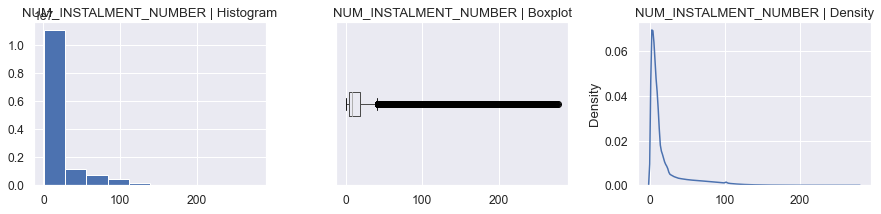

In [106]:
# Quick Visualization for numerical variables
num_plot(ins, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

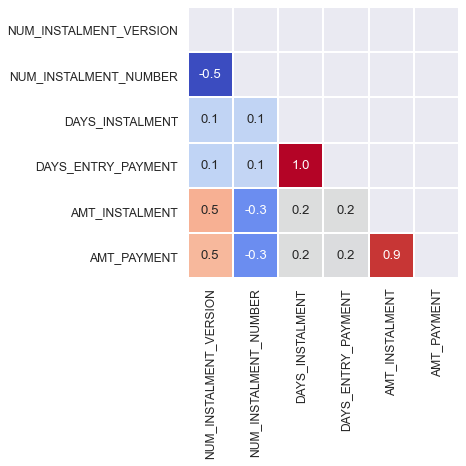

In [107]:
# Correlation
corr_plot(ins, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (5,5))

In [108]:
high_correlation(ins, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", corr_value = 0.7)

DAYS_INSTALMENT
-------------------------------
DAYS_ENTRY_PAYMENT   1.00
Name: DAYS_INSTALMENT, dtype: float64


DAYS_ENTRY_PAYMENT
-------------------------------
DAYS_INSTALMENT   1.00
Name: DAYS_ENTRY_PAYMENT, dtype: float64


AMT_INSTALMENT
-------------------------------
AMT_PAYMENT   0.92
Name: AMT_INSTALMENT, dtype: float64


AMT_PAYMENT
-------------------------------
AMT_INSTALMENT   0.92
Name: AMT_PAYMENT, dtype: float64




### Data Manipulation & Feature Engineering for Installments Payments

In [109]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

In [110]:
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

In [111]:
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'NUM_INSTALMENT_NUMBER': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'median', 'std'],
    'DPD': ['max', 'mean', 'sum', 'median', 'std'],
    'DBD': ['max', 'mean', 'sum', 'median', 'std'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'std', 'median'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'std', 'median']
}

ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

In [112]:
# Count installments accounts
ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()

ins_agg.reset_index(inplace = True)

In [113]:
del ins

In [114]:
print("INSTALLMENTS PAYMENTS SHAPE:", ins_agg.shape, "\n")
ins_agg.head()

INSTALLMENTS PAYMENTS SHAPE: (339587, 49) 



,SK_ID_CURR,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_NUM_INSTALMENT_NUMBER_MAX,INS_NUM_INSTALMENT_NUMBER_MEAN,INS_NUM_INSTALMENT_NUMBER_SUM,INS_NUM_INSTALMENT_NUMBER_MEDIAN,INS_NUM_INSTALMENT_NUMBER_STD,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_SUM,INS_DAYS_INSTALMENT_MEDIAN,INS_DAYS_INSTALMENT_STD,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_ENTRY_PAYMENT_MEDIAN,INS_DAYS_ENTRY_PAYMENT_STD,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEDIAN,INS_AMT_INSTALMENT_STD,INS_AMT_PAYMENT_MIN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_AMT_PAYMENT_MEDIAN,INS_AMT_PAYMENT_STD,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_DPD_MEDIAN,INS_DPD_STD,INS_DBD_MAX,INS_DBD_MEAN,INS_DBD_SUM,INS_DBD_MEDIAN,INS_DBD_STD,INS_PAYMENT_PERC_MAX,INS_PAYMENT_PERC_MEAN,INS_PAYMENT_PERC_SUM,INS_PAYMENT_PERC_STD,INS_PAYMENT_PERC_MEDIAN,INS_PAYMENT_DIFF_MAX,INS_PAYMENT_DIFF_MEAN,INS_PAYMENT_DIFF_SUM,INS_PAYMENT_DIFF_STD,INS_PAYMENT_DIFF_MEDIAN,INS_COUNT
0,100001,2,4,2.71,19.00,3.00,1.11,"-1,619.00","-2,188.00","-15,312.00","-1,709.00",653.99,"-1,628.00","-2,196.00","-15,368.00","-1,715.00",644.08,"17,397.90","5,885.13","41,195.93","3,980.93","5,076.68","3,951.00","17,397.90","5,885.13","41,195.93","3,980.93","5,076.68",10.00,1.43,10.00,0.00,3.78,36.00,8.86,62.00,6.00,12.81,1.00,1.00,7.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,7
1,100002,2,19,10.00,190.00,10.00,5.63,-25.00,-295.00,"-5,604.00",-295.00,168.82,-49.00,-315.50,"-5,992.00",-312.00,172.06,"53,093.75","11,559.25","219,625.70","9,251.78","10,058.04","9,251.78","53,093.75","11,559.25","219,625.70","9,251.78","10,058.04",0.00,0.00,0.00,0.00,0.00,31.00,20.42,388.00,19.00,4.93,1.00,1.00,19.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,19
2,100003,2,12,5.08,127.00,5.00,3.13,-536.00,"-1,378.00","-34,464.00",-797.00,757.45,-544.00,"-1,385.00","-34,624.00",-806.00,757.37,"560,835.38","64,754.59","1,618,864.62","64,275.61","110,542.59","6,662.97","560,835.38","64,754.59","1,618,864.62","64,275.61","110,542.59",0.00,0.00,0.00,0.00,0.00,14.00,7.20,180.00,6.00,3.72,1.00,1.00,25.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,25
3,100004,2,3,2.00,6.00,2.00,1.00,-724.00,-754.00,"-2,262.00",-754.00,30.00,-727.00,-761.50,"-2,284.00",-763.00,34.02,"10,573.96","7,096.15","21,288.46","5,357.25","3,011.87","5,357.25","10,573.96","7,096.15","21,288.46","5,357.25","3,011.87",0.00,0.00,0.00,0.00,0.00,11.00,7.67,23.00,9.00,4.16,1.00,1.00,3.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,3
4,100005,2,9,5.00,45.00,5.00,2.74,-466.00,-586.00,"-5,272.00",-586.00,82.16,-470.00,-609.50,"-5,488.00",-585.00,90.55,"17,656.24","6,240.21","56,161.84","4,813.20","4,281.01","4,813.20","17,656.24","6,240.21","56,161.84","4,813.20","4,281.01",1.00,0.11,1.00,0.00,0.33,37.00,23.67,213.00,29.00,13.29,1.00,1.00,9.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,9


In [115]:
# WRITE FEATHER
ins_agg.to_feather("installments_payments_agg_feather")

In [116]:
del ins_agg

# 6) Previous Applications

### Description 
1. All previous applications for Home Credit loans of clients who have loans in our sample.
2. There is one row for each previous application related to loans in our data sample.

In [117]:
prev = pd.read_csv('previous_application.csv')
prev = reduce_mem_usage(prev)

print('shape :', prev.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(prev, car_th=10)

print("")

prev.head()

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
shape : (1670214, 37) 

Observations: 1670214
Variables: 37
date_cols: 0
cat_cols: 13
num_cols: 5
cat_but_car: 4
num_but_cat: 1



,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,"1,730.43","17,145.00","17,145.00",0.00,"17,145.00",SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,"365,243.00",-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,"25,188.62","607,500.00","679,671.00",NaN,"607,500.00",THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,"365,243.00",-134.00,916.00,"365,243.00","365,243.00",1.00
2,2523466,122040,Cash loans,"15,060.74","112,500.00","136,444.50",NaN,"112,500.00",TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,high,Cash X-Sell: high,"365,243.00",-271.00,59.00,"365,243.00","365,243.00",1.00
3,2819243,176158,Cash loans,"47,041.34","450,000.00","470,790.00",NaN,"450,000.00",MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,middle,Cash X-Sell: middle,"365,243.00",-482.00,-152.00,-182.00,-177.00,1.00
4,1784265,202054,Cash loans,"31,924.39","337,500.00","404,055.00",NaN,"337,500.00",THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


### EDA for Previous Applications

In [118]:
# Are there any missing values in the data?
missing_values(prev, plot = False)

Number of Variables include Missing Values: 16 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0    RATE_INTEREST_PRIVILEGED      1664263           1.00   float16
1       RATE_INTEREST_PRIMARY      1664263           1.00   float16
2            AMT_DOWN_PAYMENT       895844           0.54   float32
3           RATE_DOWN_PAYMENT       895844           0.54   float16
4             NAME_TYPE_SUITE       820405           0.49  category
5   NFLAG_INSURED_ON_APPROVAL       673065           0.40   float16
6            DAYS_TERMINATION       673065           0.40   float32
7               DAYS_LAST_DUE       673065           0.40   float32
8   DAYS_LAST_DUE_1ST_VERSION       673065           0.40   float32
9              DAYS_FIRST_DUE       673065           0.40   float32
10         DAYS_FIRST_DRAWING       673065           0.40   float32
11            AMT_GOODS_PRICE       385515           0.23   float32
12                AMT_ANNUITY       372235           0.22   float32

In [119]:
for i in cat_cols + cat_but_car + num_but_cat:
    cat_analyzer(prev, i)

NAME_CONTRACT_TYPE
                  COUNT  RATIO
Cash loans       747553   0.45
Consumer loans   729151   0.44
Revolving loans  193164   0.12
XNA                 346   0.00


WEEKDAY_APPR_PROCESS_START
            COUNT  RATIO
TUESDAY    255118   0.15
WEDNESDAY  255010   0.15
MONDAY     253557   0.15
FRIDAY     252048   0.15
THURSDAY   249099   0.15
SATURDAY   240631   0.14
SUNDAY     164751   0.10


FLAG_LAST_APPL_PER_CONTRACT
     COUNT  RATIO
Y  1661739   0.99
N     8475   0.01


NAME_CONTRACT_STATUS
                COUNT  RATIO
Approved      1036781   0.62
Canceled       316319   0.19
Refused        290678   0.17
Unused offer    26436   0.02


NAME_PAYMENT_TYPE
                                             COUNT  RATIO
Cash through the bank                      1033552   0.62
XNA                                         627384   0.38
Non-cash from your account                    8193   0.00
Cashless from the account of the employer     1085   0.00


CODE_REJECT_REASON
          COUN

In [120]:
# Numeric Features
prev.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
mean,"15,948.89","174,980.64","196,013.12","6,699.08","227,518.19",12.48,1.00,0.08,0.19,0.77,-880.68,313.95,NaN,"340,114.34","13,838.13","33,764.87","76,829.15","82,314.84",NaN
std,"14,776.95","293,300.53","317,783.66","20,905.72","315,460.50",3.33,0.06,0.11,0.09,0.10,779.10,"7,127.44",0.00,"88,611.61","72,421.30","106,544.81","150,155.11","152,926.94",0.00
min,0.00,0.00,0.00,-0.90,0.00,0.00,0.00,-0.00,0.03,0.37,"-2,922.00",-1.00,0.00,"-2,922.00","-2,892.00","-2,801.00","-2,889.00","-2,874.00",0.00
1%,"2,137.18",0.00,0.00,0.00,"15,300.00",5.00,1.00,0.00,0.06,0.42,"-2,835.00",-1.00,0.00,"-2,441.00","-2,822.00","-2,599.00","-2,618.00","-2,589.00",0.00
10%,"3,817.53",0.00,0.00,0.00,"30,555.00",8.00,1.00,0.00,0.14,0.64,"-2,250.00",-1.00,0.00,"365,243.00","-2,392.00","-2,047.00","-2,081.00","-2,052.00",0.00
25%,"6,321.78","18,720.00","24,160.50",0.00,"50,841.00",10.00,1.00,0.00,0.16,0.72,"-1,300.00",-1.00,6.00,"365,243.00","-1,628.00","-1,242.00","-1,314.00","-1,270.00",0.00
50%,"11,250.00","71,046.00","80,541.00","1,638.00","112,320.00",12.00,1.00,0.05,0.19,0.83,-581.00,3.00,12.00,"365,243.00",-831.00,-361.00,-537.00,-499.00,0.00
75%,"20,658.42","180,360.00","216,418.50","7,740.00","234,000.00",15.00,1.00,0.11,0.19,0.85,-280.00,82.00,24.00,"365,243.00",-411.00,129.00,-74.00,-44.00,1.00
80%,"23,638.50","228,937.50","270,000.00","9,450.00","315,000.00",16.00,1.00,0.11,0.19,0.85,-239.00,140.00,24.00,"365,243.00",-332.00,267.00,"365,243.00","365,243.00",1.00
90%,"34,703.82","450,000.00","533,160.00","17,109.00","585,000.00",17.00,1.00,0.21,0.20,0.87,-152.00,919.00,36.00,"365,243.00",-173.00,"1,432.00","365,243.00","365,243.00",1.00


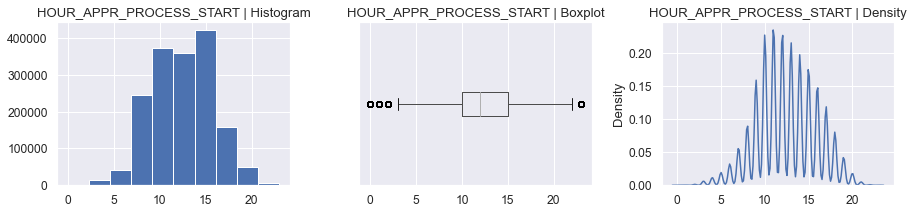

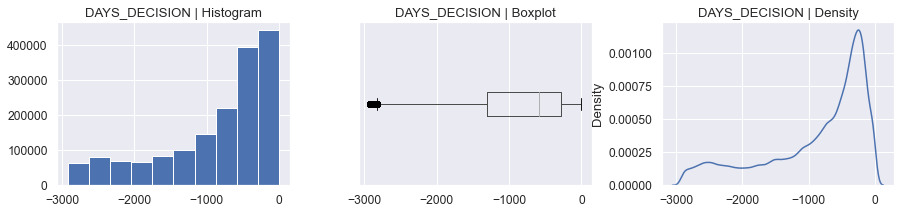

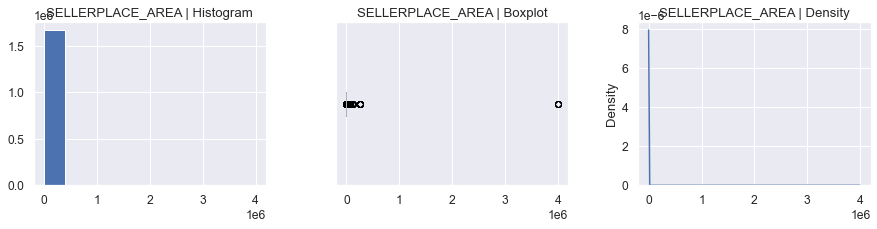

In [121]:
# Quick Visualization for numerical variables
num_plot(prev, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

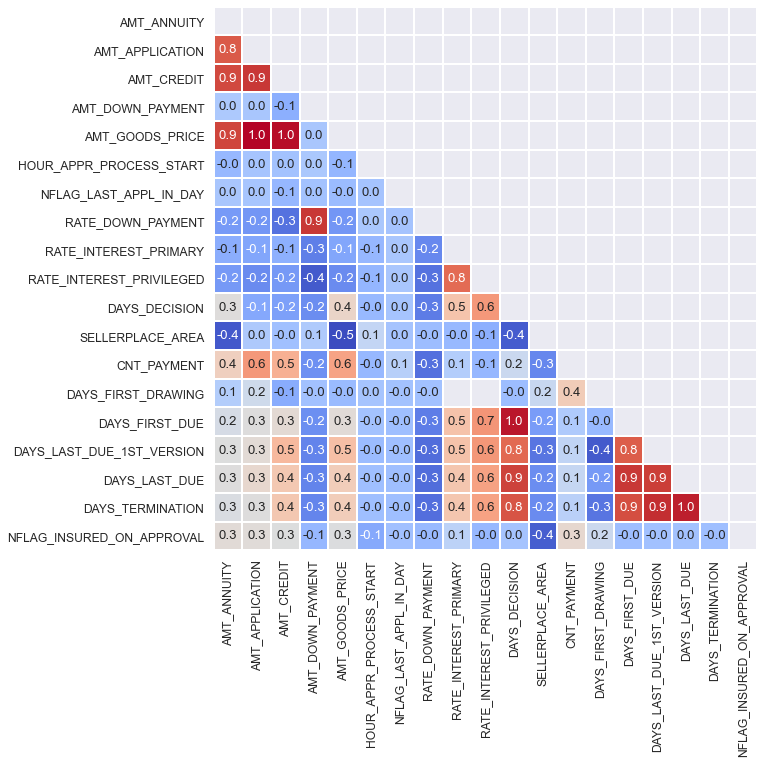

In [122]:
# Correlation
corr_plot(prev, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (10,10))

In [123]:
high_correlation(prev, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", corr_value = 0.7)

AMT_ANNUITY
-------------------------------
AMT_GOODS_PRICE   0.89
AMT_CREDIT        0.88
AMT_APPLICATION   0.83
Name: AMT_ANNUITY, dtype: float64


AMT_APPLICATION
-------------------------------
AMT_GOODS_PRICE   1.00
AMT_CREDIT        0.92
AMT_ANNUITY       0.83
Name: AMT_APPLICATION, dtype: float64


AMT_CREDIT
-------------------------------
AMT_GOODS_PRICE   0.98
AMT_APPLICATION   0.92
AMT_ANNUITY       0.88
Name: AMT_CREDIT, dtype: float64


AMT_DOWN_PAYMENT
-------------------------------
RATE_DOWN_PAYMENT   0.92
Name: AMT_DOWN_PAYMENT, dtype: float64


AMT_GOODS_PRICE
-------------------------------
AMT_APPLICATION   1.00
AMT_CREDIT        0.98
AMT_ANNUITY       0.89
Name: AMT_GOODS_PRICE, dtype: float64


RATE_DOWN_PAYMENT
-------------------------------
AMT_DOWN_PAYMENT   0.92
Name: RATE_DOWN_PAYMENT, dtype: float64


RATE_INTEREST_PRIMARY
-------------------------------
RATE_INTEREST_PRIVILEGED   0.78
Name: RATE_INTEREST_PRIMARY, dtype: float64


RATE_INTEREST_PRIVILEGED
--

### Data Manipulation & Feature Engineering for Previous Applications

In [124]:
# Rare Encoder
rare_cols = [
    "NAME_PAYMENT_TYPE", "CODE_REJECT_REASON", "CHANNEL_TYPE", "NAME_GOODS_CATEGORY",
    "NAME_SELLER_INDUSTRY", "NAME_TYPE_SUITE"
]

for i in rare_cols:
    rare_encoder(prev, i, rare_perc = 0.01)

prev["NAME_CASH_LOAN_PURPOSE"] = np.where(~prev[
    "NAME_CASH_LOAN_PURPOSE"].isin(["XAP", "XNA"]),
                                          "Other",
                                          prev["NAME_CASH_LOAN_PURPOSE"])

rare_encoder(prev, "NAME_PORTFOLIO", rare_perc = 0.1) 

In [125]:
# Cash, Pos, Card
prev["PRODUCT_COMBINATION_CATS"] = np.where(
    prev["PRODUCT_COMBINATION"].str.contains("Cash"), "CASH", "POS")
prev["PRODUCT_COMBINATION_CATS"] = np.where(
    prev["PRODUCT_COMBINATION"].str.contains("Card"), "CARD", prev["PRODUCT_COMBINATION_CATS"])

In [126]:
# New categorical variables
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where(
    (prev["PRODUCT_COMBINATION"].str.contains("POS")
     & (prev["PRODUCT_COMBINATION"].str.contains("without"))),
    "WITHOUT", "OTHER")
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where(
    (prev["PRODUCT_COMBINATION"].str.contains("POS")
     & (prev["PRODUCT_COMBINATION"].str.contains("with interest"))),
    "WITH", prev["PRODUCT_COMBINATION_POS_WITH"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where(
    (prev["PRODUCT_COMBINATION"].str.contains("POS")
     & (prev["PRODUCT_COMBINATION"].str.contains("household"))),
    "household", "OTHER")
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where(
    (prev["PRODUCT_COMBINATION"].str.contains("POS")
     & (prev["PRODUCT_COMBINATION"].str.contains("industry"))),
    "industry", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where(
    (prev["PRODUCT_COMBINATION"].str.contains("POS")
     & (prev["PRODUCT_COMBINATION"].str.contains("mobile"))),
    "mobile", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where(
    (prev["PRODUCT_COMBINATION"].str.contains("POS")
     & (prev["PRODUCT_COMBINATION"].str.contains("other"))),
    "posother", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where(
    (prev["PRODUCT_COMBINATION"].str.contains("Cash")
     & (prev["PRODUCT_COMBINATION"].str.contains("X-Sell"))),
    "xsell", "OTHER")
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where(
    (prev["PRODUCT_COMBINATION"].str.contains("Cash")
     & (prev["PRODUCT_COMBINATION"].str.contains("Street"))),
    "street", prev["PRODUCT_COMBINATION_CASH_TYPE"])

In [127]:
# Useless
prev.drop(["WEEKDAY_APPR_PROCESS_START",
           "FLAG_LAST_APPL_PER_CONTRACT",
           "NFLAG_LAST_APPL_IN_DAY",
           "NFLAG_LAST_APPL_IN_DAY"],
          axis = 1, inplace = True)

In [128]:
# One-Hot Encoder
prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

In [129]:
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

In [130]:
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

In [131]:
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean', "median", "std"],
    'AMT_APPLICATION': ['min', 'max', 'mean', "median", "std"],
    'AMT_CREDIT': ['min', 'max', 'mean', "median", "std"],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', "median", "std"],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', "median", "std"],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean', "median", "std"],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', "median", "std"],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean', "std"],
    'DAYS_DECISION': ['min', 'max', 'mean', "median", "std"],
    'CNT_PAYMENT': ['mean', 'sum', "median", "std"],
    'SELLERPLACE_AREA': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_TERMINATION': ['min', 'max', 'mean', "median", "std"],
    # Categorical
    "NFLAG_INSURED_ON_APPROVAL": ["mean"]
}

In [132]:
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

In [133]:
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg,approved_agg, how='left', on='SK_ID_CURR')

In [134]:
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg, refused_agg, how='left', on='SK_ID_CURR')

In [135]:
del refused, refused_agg, approved, approved_agg, prev

In [136]:
prev_agg.reset_index(inplace = True)

print("PREVIOUS APPLICATIONS SHAPE:", prev_agg.shape, "\n")
prev_agg.head()

PREVIOUS APPLICATIONS SHAPE: (338857, 378) 



,SK_ID_CURR,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MEDIAN,PREV_AMT_ANNUITY_STD,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MEDIAN,PREV_AMT_APPLICATION_STD,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MEDIAN,PREV_AMT_CREDIT_STD,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MEDIAN,PREV_APP_CREDIT_PERC_STD,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MEDIAN,PREV_AMT_DOWN_PAYMENT_STD,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MEDIAN,PREV_AMT_GOODS_PRICE_STD,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_HOUR_APPR_PROCESS_START_MEDIAN,PREV_HOUR_APPR_PROCESS_START_STD,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_DOWN_PAYMENT_STD,PREV_RATE_INTEREST_PRIMARY_MIN,PREV_RATE_INTEREST_PRIMARY_MAX,PREV_RATE_INTEREST_PRIMARY_MEAN,PREV_RATE_INTEREST_PRIMARY_STD,PREV_RATE_INTEREST_PRIVILEGED_MIN,PREV_RATE_INTEREST_PRIVILEGED_MAX,PREV_RATE_INTEREST_PRIVILEGED_MEAN,PREV_RATE_INTEREST_PRIVILEGED_STD,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MEDIAN,PREV_DAYS_DECISION_STD,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CNT_PAYMENT_MEDIAN,PREV_CNT_PAYMENT_STD,PREV_SELLERPLACE_AREA_MIN,PREV_SELLERPLACE_AREA_MAX,PREV_SELLERPLACE_AREA_MEAN,PREV_SELLERPLACE_AREA_MEDIAN,PREV_SELLERPLACE_AREA_STD,PREV_DAYS_FIRST_DRAWING_MIN,PREV_DAYS_FIRST_DRAWING_MAX,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DRAWING_MEDIAN,PREV_DAYS_FIRST_DRAWING_STD,PREV_DAYS_FIRST_DUE_MIN,PREV_DAYS_FIRST_DUE_MAX,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_FIRST_DUE_MEDIAN,PREV_DAYS_FIRST_DUE_STD,PREV_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MEDIAN,PREV_DAYS_LAST_DUE_1ST_VERSION_STD,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_LAST_DUE_MEDIAN,PREV_DAYS_LAST_DUE_STD,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_DAYS_TERMINATION_MEDIAN,PREV_DAYS_TERMINATION_STD,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_NAME_CONTRACT_TYPE_nan_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_CONTRACT_STATUS_nan_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Rare_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_Rare_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Rare_MEAN,"PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN",PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_Repeater_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_C

In [137]:
# WRITE FEATHER
prev_agg.to_feather("previous_applications_agg_feather")

In [138]:
del prev_agg

# 7) Application Train/Test

### Description 
1. This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
2. Static data for all applications. One row represents one loan in our data sample.

In [139]:
df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')

print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))

Train samples: 307511, test samples: 48744


In [140]:
df = df.append(test_df)
df = reduce_mem_usage(df)

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df, car_th=10)

print("")

df.head()

Memory usage of dataframe is 334.32 MB
Memory usage after optimization is: 72.03 MB
Decreased by 78.5%
Observations: 356255
Variables: 122
date_cols: 0
cat_cols: 48
num_cols: 6
cat_but_car: 2
num_but_cat: 34



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.00,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50","351,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,"-3,648.00",-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,"-1,134.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0.00,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,"-1,186.00",-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.98,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0.00,Revolving loans,M,Y,Y,0,"67,500.00","135,000.00","6,750.00","135,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,"-4,260.00",-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-8

### Data Manipulation & Feature Engineering for Application Train/Test

In [141]:
# Are there any missing values in the data?
missing_values(df, plot = False)

Number of Variables include Missing Values: 68 

                     Feature  Num_Missing  Missing_Ratio DataTypes
0             COMMONAREA_AVG       248360           0.70   float16
1            COMMONAREA_MODE       248360           0.70   float16
2            COMMONAREA_MEDI       248360           0.70   float16
3    NONLIVINGAPARTMENTS_AVG       246861           0.69   float16
4   NONLIVINGAPARTMENTS_MODE       246861           0.69   float16
..                       ...          ...            ...       ...
63              EXT_SOURCE_2          668           0.00   float16
64           AMT_GOODS_PRICE          278           0.00   float32
65               AMT_ANNUITY           36           0.00   float32
66           CNT_FAM_MEMBERS            2           0.00   float16
67    DAYS_LAST_PHONE_CHANGE            1           0.00   float16

[68 rows x 4 columns] 



In [142]:
for i in cat_cols + cat_but_car + num_but_cat:
    cat_analyzer(df, i, target = "TARGET")

NAME_CONTRACT_TYPE
                  COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  \
Cash loans       326537   0.92        278232         0.08           0.00   
Revolving loans   29718   0.08         29279         0.05           0.00   

                 TARGET_STD  
Cash loans             0.28  
Revolving loans        0.23  


CODE_GENDER
      COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
F    235126   0.66        202448         0.07           0.00        0.26
M    121125   0.34        105059         0.10           0.00        0.30
XNA       4   0.00             4         0.00           0.00        0.00


FLAG_OWN_CAR
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
N  235235   0.66        202924         0.09           0.00        0.28
Y  121020   0.34        104587         0.07           0.00        0.26


FLAG_OWN_REALTY
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
N  109285   0.31         94199         

    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0       2   0.00             1         0.00           0.00         NaN
1  356253   1.00        307510         0.08           0.00        0.27


FLAG_EMP_PHONE
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0   64661   0.18         55386         0.05           0.00        0.23
1  291594   0.82        252125         0.09           0.00        0.28


FLAG_WORK_PHONE
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  284969   0.80        246203         0.08           0.00        0.27
1   71286   0.20         61308         0.10           0.00        0.30


FLAG_CONT_MOBILE
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0     652   0.00           574         0.08           0.00        0.27
1  355603   1.00        306937         0.08           0.00        0.27


FLAG_PHONE
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  256998 

                        COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  \
Advertising               500   0.00           429         0.08   
Agriculture              2746   0.01          2454         0.10   
Bank                     2881   0.01          2507         0.05   
Business Entity Type 1   6871   0.02          5984         0.08   
Business Entity Type 2  12032   0.03         10553         0.09   
Business Entity Type 3  78832   0.22         67992         0.09   
Cleaning                  303   0.00           260         0.11   
Construction             7760   0.02          6721         0.12   
Culture                   440   0.00           379         0.06   
Electricity              1106   0.00           950         0.07   
Emergency                 651   0.00           560         0.07   
Government              11912   0.03         10404         0.07   
Hotel                    1100   0.00           966         0.06   
Housing                  3393   0.01          2958         0.0

     COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
-1       1   0.00             0          NaN            NaN         NaN
 1   40342   0.11         34167         0.05           0.00        0.21
 2  265260   0.74        229484         0.08           0.00        0.27
 3   50652   0.14         43860         0.11           0.00        0.32


REG_REGION_NOT_LIVE_REGION
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  350680   0.98        302854         0.08           0.00        0.27
1    5575   0.02          4657         0.09           0.00        0.29


REG_REGION_NOT_WORK_REGION
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  337954   0.95        291899         0.08           0.00        0.27
1   18301   0.05         15612         0.09           0.00        0.28


LIVE_REGION_NOT_WORK_REGION
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
0  341703   0.96        295008         0.08           0

In [143]:
# Numeric Features
df.drop(["SK_ID_CURR" ], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
mean,0.08,0.41,"170,007.72","587,568.62","27,428.09","527,535.12",0.02,"-16,041.25","64,317.23",NaN,"-3,002.07",NaN,1.00,0.82,0.20,1.00,0.28,0.07,NaN,2.05,2.03,12.06,0.02,0.05,0.04,0.08,0.23,0.18,NaN,NaN,NaN,0.12,0.09,NaN,NaN,0.05,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,NaN,NaN,0.04,0.08,0.15,0.22,0.23,0.07,0.11,0.11,0.01,0.03,0.12,0.09,NaN,NaN,0.05,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.10,NaN,0.14,NaN,0.10,NaN,0.00,0.72,0.00,0.02,0.09,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.03,NaN,NaN,NaN
std,0.27,0.72,"223,490.95","398,634.47","14,731.54","365,942.41",0.01,"4,358.80","141,705.53",NaN,"1,517.90",0.00,0.00,0.39,0.40,0.04,0.45,0.26,0.00,0.51,0.50,3.27,0.12,0.22,0.20,0.27,0.42,0.38,0.00,0.00,0.00,0.11,0.08,0.00,0.00,0.08,0.14,0.10,0.15,0.16,0.08,0.09,0.11,0.05,0.07,0.11,0.08,0.00,0.00,0.08,0.13,0.10,0.14,0.16,0.08,0.10,0.11,0.05,0.07,0.11,0.08,0.00,0.00,0.08,0.14,0.10,0.15,0.16,0.08,0.09,0.11,0.05,0.07,0.11,NaN,0.00,NaN,0.37,NaN,0.01,0.45,0.01,0.12,0.28,0.01,0.27,0.06,0.00,0.06,0.00,0.06,0.05,0.03,0.09,0.02,0.08,0.02,0.02,0.02,0.08,0.10,0.19,0.00,NaN,0.00
min,0.00,0.00,"25,650.00","45,000.00","1,615.50","40,500.00",0.00,"-25,229.00","-17,912.00","-24,672.00","-7,197.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"-4,360.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,0.00,0.00,"45,000.00","76,410.00","6,142.50","67,500.00",0.00,"-24,404.00","-10,856.00","-13,896.00","-5,476.00",0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.03,0.07,0.00,0.00,0.95,0.35,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.37,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

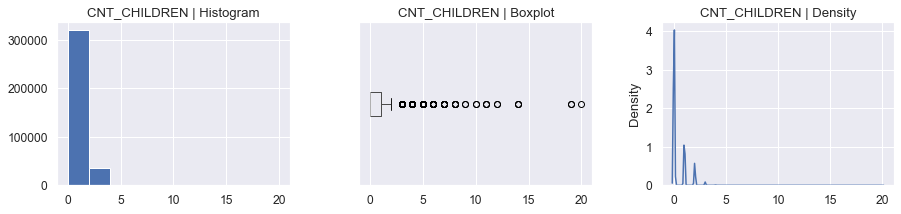

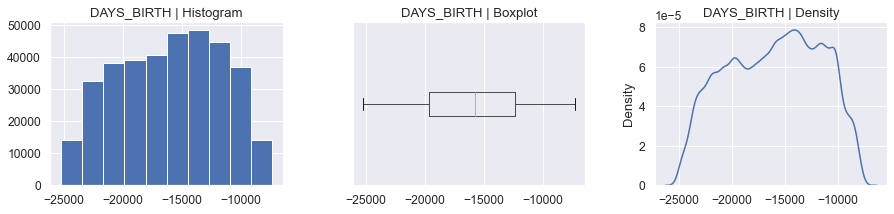

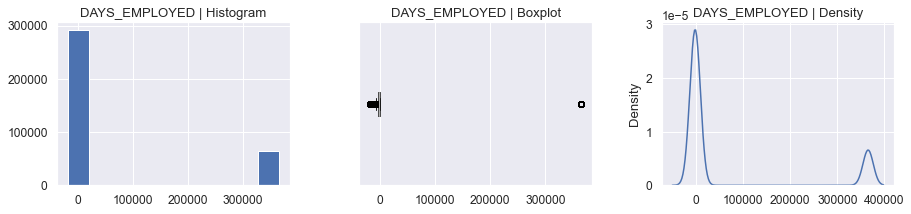

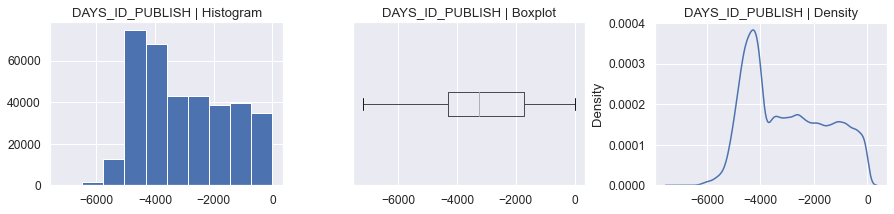

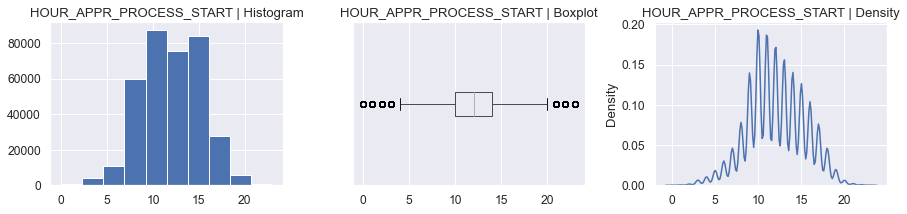

In [144]:
# Quick Visualization for numerical variables
num_plot(df, num_cols=num_cols, remove=['SK_ID_CURR'], figsize = (15,3))

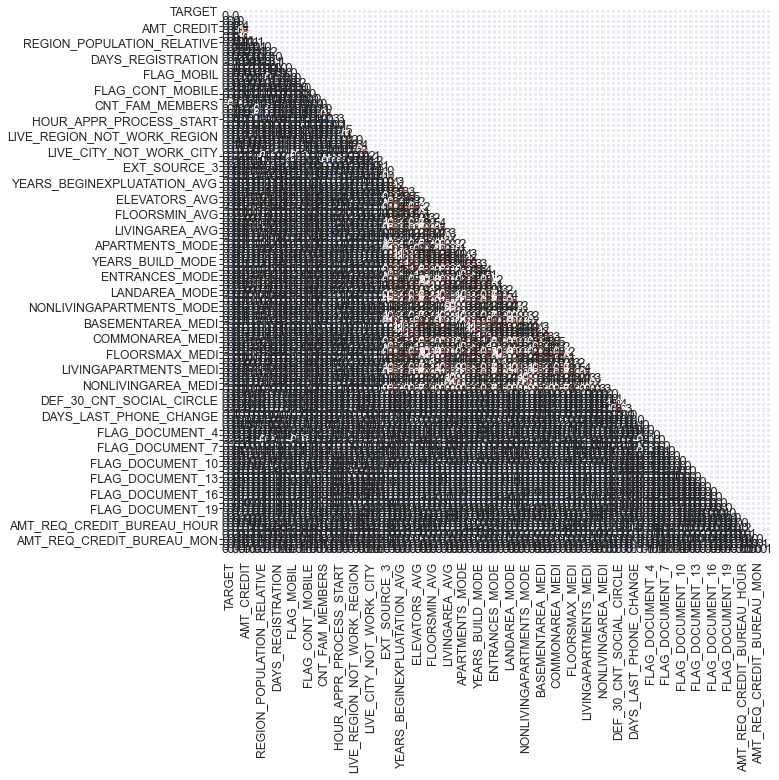

In [145]:
# Correlation
corr_plot(df, remove=['SK_ID_CURR'], corr_coef = "spearman", figsize = (10,10))

In [146]:
high_correlation(df, remove=['SK_ID_CURR'], corr_coef = "spearman", corr_value = 0.7)

CNT_CHILDREN
-------------------------------
CNT_FAM_MEMBERS   0.81
Name: CNT_CHILDREN, dtype: float64


AMT_CREDIT
-------------------------------
AMT_GOODS_PRICE   0.98
AMT_ANNUITY       0.82
Name: AMT_CREDIT, dtype: float64


AMT_ANNUITY
-------------------------------
AMT_CREDIT        0.82
AMT_GOODS_PRICE   0.82
Name: AMT_ANNUITY, dtype: float64


AMT_GOODS_PRICE
-------------------------------
AMT_CREDIT    0.98
AMT_ANNUITY   0.82
Name: AMT_GOODS_PRICE, dtype: float64


CNT_FAM_MEMBERS
-------------------------------
CNT_CHILDREN   0.81
Name: CNT_FAM_MEMBERS, dtype: float64


REGION_RATING_CLIENT
-------------------------------
REGION_RATING_CLIENT_W_CITY   0.95
Name: REGION_RATING_CLIENT, dtype: float64


REGION_RATING_CLIENT_W_CITY
-------------------------------
REGION_RATING_CLIENT   0.95
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64


REG_REGION_NOT_WORK_REGION
-------------------------------
LIVE_REGION_NOT_WORK_REGION   0.86
Name: REG_REGION_NOT_WORK_REGION, dtype: flo

In [147]:
# ERRORS
df = df[~(df.CODE_GENDER.str.contains("XNA"))]  
df = df[df.NAME_FAMILY_STATUS != "Unknown"]  

In [148]:
# DROP
cols = ["NAME_HOUSING_TYPE", "WEEKDAY_APPR_PROCESS_START",
        "FONDKAPREMONT_MODE", "WALLSMATERIAL_MODE", "HOUSETYPE_MODE",
        "EMERGENCYSTATE_MODE","FLAG_MOBIL", "FLAG_EMP_PHONE","FLAG_WORK_PHONE",
        "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]
df.drop(cols, axis = 1, inplace = True)

In [149]:
# REGION
cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION",
        "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
        "REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
df["REGION"] = df[cols].sum(axis = 1)
df.drop(cols, axis = 1, inplace = True)

In [150]:
# Drop FLAG_DOCUMENT 
df.drop(df.columns[df.columns.str.contains("FLAG_DOCUMENT")], axis = 1, inplace = True)

In [151]:
# RARE ENCODER

# NAME_EDUCATION_TYPE
df["NAME_EDUCATION_TYPE"] = np.where(
    df.NAME_EDUCATION_TYPE == "Academic degree",
    "Higher education", df.NAME_EDUCATION_TYPE)

# ORGANIZATION_TYPE
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.str.contains("Business Entity"),
    "Business Entity", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.str.contains("Industry"),
    "Industry", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.str.contains("Trade"),
    "Trade", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.str.contains("Transport"),
    "Transport", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]),
    "Education", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine","Goverment",
                               "Postal", "Military", "Security Ministries", "Legal Services"]),
    "Public", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]),
    "Finance", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]),
    "House", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]),
    "HotelRestaurant", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(
    df.ORGANIZATION_TYPE.isin(["Cleaning","Electricity", "Telecom",
                               "Mobile", "Advertising", "Religion", "Culture"]),
    "Other", df.ORGANIZATION_TYPE)

# OCCUPATION_TYPE
df["OCCUPATION_TYPE"] = np.where(
    df.OCCUPATION_TYPE.isin(["Low-skill Laborers", "Cooking staff",
                             "Security staff", "Private service staff",
                             "Cleaning staff", "Waiters/barmen staff"]),
    "Low-skill Laborers", df.OCCUPATION_TYPE)
df["OCCUPATION_TYPE"] = np.where(
    df.OCCUPATION_TYPE.isin(["IT staff", "High skill tech staff"]),
    "High skill tech staff", df.OCCUPATION_TYPE)

In [152]:
rare_cols = ["NAME_TYPE_SUITE", "NAME_INCOME_TYPE"]

for i in rare_cols:
    rare_encoder(df, i, rare_perc = 0.01)

In [153]:
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])

In [154]:
# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df, nan_as_category=False)

In [155]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [156]:
# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# EXT SOURCE MEAN FROM OTHER ASSOCIATIONS 
df["NEW_EXT_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_APP_EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# The ratio of the product to be purchased to the total loan amount
df["NEW_GOODS_CREDIT"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]

# Ratio of the annual payment of the loan to the total revenue of the customer
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# Ratio of the annual payment of the loan to the total revenue of the customer
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# The ratio of the difference between the product and the loan to the total annual revenue
df["NEW_C_GP"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]

# At the time of application, the customer's age in days is given as minus
# We find how old he is when we multiply by -1 and divide by 365.
df["NEW_APP_AGE"] = round(df["DAYS_BIRTH"] * -1 / 365)

df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# the price of the product from which the loan is drawn / the amount of the loan
df["NEW_APP_GOODS/AMT_CREDIT"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]

df['NEW_LOAN_VALUE_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

df['NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON'] = df['NEW_INCOME_PER_PERSON'] / df['NEW_PAYMENT_RATE']


In [157]:
print("APPLICATION TRAIN/TEST SHAPE:", df.shape, "\n")
df.head()

APPLICATION TRAIN/TEST SHAPE: (356249, 145) 



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_APP_EXT_SOURCES_PROD,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_PAYMENT_RATE,NEW_APP_GOODS/AMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON
0,100002,1.00,0,0,0,0,0,"202,500.00","406,597.50","24,700.50","351,000.00",0.02,-9461,-637.00,"-3,648.00",-2120,NaN,1.00,2,2,10,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.01,2.00,2.00,2.00,2.00,"-1,134.00",0.00,0.00,0.00,0.00,0.00,1.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0.50,"202,500.00",0.12,0.06,0.16,0.00,0.86,0.12,-0.27,26.00,"202,500.00",0.06,0.86,1.16,0.07,"3,333,373.50"
1,100003,0.00,0,1,0,1,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",0.00,-16765,"-1,188.00","-1,186.00",-291,NaN,2.00,1,1,11,0.31,0.62,NaN,0.10,0.

In [158]:
# WRITE FEATHER
df.reset_index(drop = True).to_feather("applications_traintest_feather")

In [159]:
del df

In [202]:
gc.collect()

1345

# Préparation du fichier final

In [4]:
df = pd.read_feather("applications_traintest_feather")
bureau_balance = pd.read_feather("bureau_bureaubalance_agg_feather")
pos = pd.read_feather("poscashbalance_agg_feather")
cc = pd.read_feather("cc_feather")
ins = pd.read_feather("installments_payments_agg_feather")
prev = pd.read_feather("previous_applications_agg_feather")

In [5]:
print("DIMENSIONS :\n")

dict_df = {'application_train_test shape :': df.shape, 
           'bureau_balance shape :' : bureau_balance.shape,
           'POS_CASH_balance shape :' : pos.shape, 
           'credit_card_balance shape :' : cc.shape, 
           'installments_payments shape :' : ins.shape, 
           'previous_application shape:' : prev.shape}

for key, value in dict_df.items():
    print(f'{key :-<32} {value}')

DIMENSIONS :

application_train_test shape :-- (356249, 145)
bureau_balance shape :---------- (305811, 456)
POS_CASH_balance shape :-------- (337252, 23)
credit_card_balance shape :----- (103558, 117)
installments_payments shape :--- (339587, 49)
previous_application shape:----- (338857, 378)


In [6]:
# merge all the files
for i in [pos, bureau_balance, cc, ins, prev]:
    df = pd.merge(df, i , how = "left", on = "SK_ID_CURR")
    
print('Total shape :', df.shape)

Total shape : (356249, 1163)


In [7]:
del pos, bureau_balance, ins, cc, prev

In [8]:
# rename cols
df.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").upper(),
                      df.columns))
#re.sub(pattern, repl, string, count=0, flags=0)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_RARE,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_RARE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BUSINESS_ENTITY,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_EDUCATION,ORGANIZATION_TYPE_FINANCE,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTELRESTAURANT,ORGANIZATION_TYPE_HOUSE,ORGANIZATION_TYPE_INDUSTRY,ORGANIZATION_TYPE_OTHER,ORGANIZATION_TYPE_PUBLIC,ORGANIZATION_TYPE_SECURITY,ORGANIZATION_TYPE_SELF_EMPLOYED,ORGANIZATION_TYPE_SERVICES,ORGANIZATION_TYPE_TRADE,ORGANIZATION_TYPE_TRANSPORT,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_APP_EXT_SOURCES_PROD,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_PAYMENT_RATE,NEW_APP_GOODSAMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,POS_NAME_CONTRACT_STATUS_COMPLETED_MEAN,POS_NAME_CONTRACT_STATUS_RARE_MEAN,POS_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_M

#### Taux de remplissage des colonnes

In [9]:
T=round(df.count().sum()/(len(df)*len(df.columns))*100,2)
print('Le taux de remplissage total du dataframe est de :', T,'%' )

Le taux de remplissage total du dataframe est de : 58.0 %


In [10]:
Taux=pd.DataFrame([{'colonne':cols, 
                    'taux': round(df[cols].count()/len(df),2), 
                    'taux_missing':round(1-df[cols].count()/len(df),2)} for cols in df.columns])
Taux.head(10)

,colonne,taux,taux_missing
0,SK_ID_CURR,1.00,0.00
1,TARGET,0.86,0.14
2,NAME_CONTRACT_TYPE,1.00,0.00
3,CODE_GENDER,1.00,0.00
4,FLAG_OWN_CAR,1.00,0.00
5,FLAG_OWN_REALTY,1.00,0.00
6,CNT_CHILDREN,1.00,0.00
7,AMT_INCOME_TOTAL,1.00,0.00
8,AMT_CREDIT,1.00,0.00
9,AMT_ANNUITY,1.00,0.00


In [11]:
print('Taux...')
for i in range(10):
    full_ft = list(Taux[Taux['taux']>=i*0.1].colonne)
    T=round(df[full_ft].count().sum()/(len(df)*len(full_ft))*100,2)
    print('...mini des colonnes', round(i*0.1,2), '...remplissage du df :', T,'%', '>> nbr_cols_restantes:', len(full_ft))

Taux...
...mini des colonnes 0.0 ...remplissage du df : 58.0 % >> nbr_cols_restantes: 1163
...mini des colonnes 0.1 ...remplissage du df : 66.59 % >> nbr_cols_restantes: 1011
...mini des colonnes 0.2 ...remplissage du df : 68.44 % >> nbr_cols_restantes: 976
...mini des colonnes 0.3 ...remplissage du df : 76.16 % >> nbr_cols_restantes: 823
...mini des colonnes 0.4 ...remplissage du df : 85.33 % >> nbr_cols_restantes: 675
...mini des colonnes 0.5 ...remplissage du df : 87.24 % >> nbr_cols_restantes: 644
...mini des colonnes 0.6 ...remplissage du df : 88.91 % >> nbr_cols_restantes: 613
...mini des colonnes 0.7 ...remplissage du df : 90.09 % >> nbr_cols_restantes: 582
...mini des colonnes 0.8 ...remplissage du df : 93.87 % >> nbr_cols_restantes: 474
...mini des colonnes 0.9 ...remplissage du df : 96.21 % >> nbr_cols_restantes: 362


On ne conserve que les variables remplie à au moins 40 %, soit 675 variables, pour un taux de remplissage totale de 85.33%.

In [12]:
full_ft = list(Taux[Taux['taux']>=0.4].colonne)

# just in case : 
if 'TARGET' not in full_ft :
    full_ft.append('TARGET')

In [13]:
Taux=pd.DataFrame([{'colonne':cols, 
                    'taux': round(df[cols].count()/len(df),2), 
                    'taux_missing':round(1-df[cols].count()/len(df),2)} for cols in full_ft])
Taux

,colonne,taux,taux_missing
0,SK_ID_CURR,1.00,0.00
1,TARGET,0.86,0.14
2,NAME_CONTRACT_TYPE,1.00,0.00
3,CODE_GENDER,1.00,0.00
4,FLAG_OWN_CAR,1.00,0.00
...,...,...,...
670,APPROVED_DAYS_TERMINATION_MAX,0.87,0.13
671,APPROVED_DAYS_TERMINATION_MEAN,0.87,0.13
672,APPROVED_DAYS_TERMINATION_MEDIAN,0.87,0.13
673,APPROVED_DAYS_TERMINATION_STD,0.55,0.45


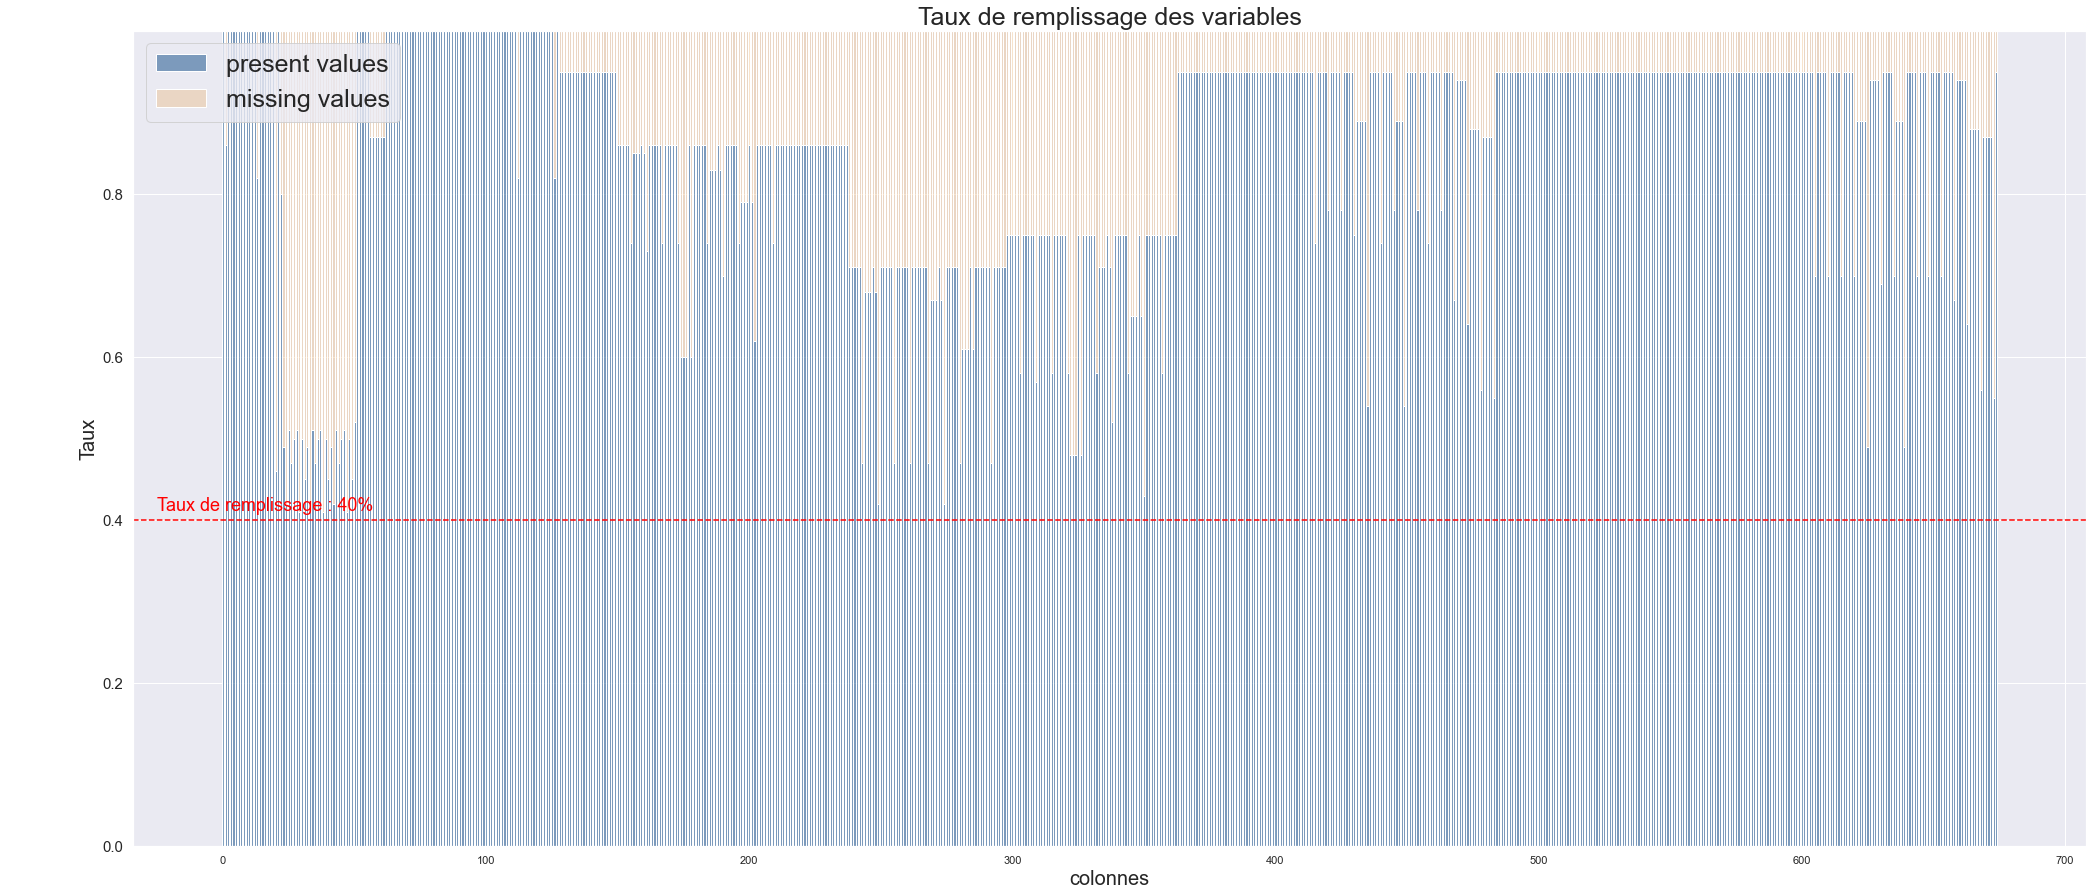

In [14]:
fig,ax=plt.subplots(figsize=(35,15))

present = Taux['taux']
missing = Taux['taux_missing']
ind = np.arange(len(Taux))    # the x locations for the groups

p1 = plt.bar(ind, present,color=(0.2, 0.4, 0.6, 0.6))
p2 = plt.bar(ind, missing, bottom=present, color=(0.92, 0.73, 0.5,0.4))

ax.axhline(y=0.4, color='red', ls='--')
ax.annotate('Taux de remplissage : 40%', xy=(0.075, 0.43), xycoords='figure fraction', size=18, color='red')

plt.xlabel('colonnes', fontsize=20)
plt.ylabel('Taux', fontsize=20)
plt.yticks(np.arange(0, 1, 0.2), fontsize=15)

plt.title('Taux de remplissage des variables',  fontsize=25)

_=plt.legend((p1[0], p2[0]), ('present values', 'missing values'),fontsize=25)

In [15]:
df = df[full_ft]

In [16]:
# WRITE FEATHER
df.reset_index(drop = True).to_feather("full_df_ready_feather")

# ------- PEP 8 -------

In [ ]:
%load_ext pycodestyle_magic
%pycodestyle_on